# IMPORT LIBRARIES

In [1]:
import pandas as pd
import random
from pyomo.environ import *
import numpy as np
import time
import matplotlib.pyplot as plt


# IMPORT DATA

In [ ]:
# --------------------------
# Synthetic dataset generator
# --------------------------
np.random.seed(42)  # reproducibility

n_rows = 500

# Ranges / progressive labels
ordini = [f"ORD_{i}" for i in range(1, 1001)]
articoli = [f"ART_{i}" for i in range(1, 201)]
clienti = [f"CLI_{i}" for i in range(1, 101)]
percorsi = [f"PER_{i}" for i in range(1, 31)]
ecr1_vals = [f"ECR1_{i}" for i in range(1, 6)]
ecr2_vals = [f"ECR2_{i}" for i in range(1, 20)]
ecr3_vals = [f"ECR3_{i}" for i in range(1, 100)]
ecr4_vals = [f"ECR4_{i}" for i in range(1, 300)]

# Build DataFrame
df = pd.DataFrame({
    "Num. Ordine": np.random.choice(ordini, n_rows),
    "Mese-Giorno": pd.date_range("2025-01-01", periods=n_rows, freq="D").strftime("%m-%d"),
    "Articolo": np.random.choice(articoli, n_rows),
    "Pezzi evasi": np.random.randint(1, 12, n_rows),
    "Ecr1": np.random.choice(ecr1_vals, n_rows),
    "Ecr2": np.random.choice(ecr2_vals, n_rows),
    "Ecr3": np.random.choice(ecr3_vals, n_rows),
    "Ecr4": np.random.choice(ecr4_vals, n_rows),
    "Cliente": np.random.choice(clienti, n_rows),
    "Percorso": np.random.choice(percorsi, n_rows),
    "Giacenza Pezzi Volume [m3]": np.round(np.random.uniform(0.1, 10.0, n_rows), 6),
    "Volume evaso [m3]": np.round(np.random.uniform(0.001, 1.0, n_rows), 6),
})

print("✅ Synthetic dataset created:")
print(df.head())

✅ Synthetic dataset created:
  Num. Ordine Mese-Giorno Articolo  Pezzi evasi    Ecr1    Ecr2    Ecr3  \
0     ORD_103       01-01   ART_67            8  ECR1_3  ECR2_2  ECR3_3   
1     ORD_436       01-02  ART_104            5  ECR1_4  ECR2_4  ECR3_2   
2     ORD_861       01-03  ART_174            2  ECR1_2  ECR2_4  ECR3_4   
3     ORD_271       01-04   ART_24            6  ECR1_2  ECR2_5  ECR3_3   
4     ORD_107       01-05  ART_114            5  ECR1_5  ECR2_1  ECR3_3   

     Ecr4 Cliente Percorso  Giacenza Pezzi Volume [m3]  Volume evaso [m3]  
0  ECR4_3  CLI_75   PER_21                    7.067544           0.547690  
1  ECR4_1  CLI_64   PER_16                    3.795272           0.991781  
2  ECR4_4  CLI_81    PER_2                    5.680234           0.664538  
3  ECR4_1  CLI_51    PER_2                    4.561796           0.200047  
4  ECR4_5  CLI_53   PER_23                    6.753355           0.045916  


# DEFINE FUNCTIONS

In [3]:
def initial_population(gene_space, num_genes, sol_per_pop):
    """
    Generate an initial random population.
    
    Each individual is a vector of length `num_genes`, where each gene is chosen from `gene_space`.
    
    Parameters:
        gene_space (list or array): Possible gene values.
        num_genes (int): Number of genes per individual.
        sol_per_pop (int): Number of individuals (solutions) in the population.
    
    Returns:
        np.ndarray: Population array of shape (sol_per_pop, num_genes).
    """
    return np.random.choice(gene_space, size=(sol_per_pop, num_genes))

In [4]:
gene_space = [0,1]
num_genes = len(df['Ecr3'].dropna().unique())
sol_per_pop = 4
population = initial_population(gene_space = gene_space, num_genes=num_genes, sol_per_pop=sol_per_pop)
population

array([[0, 1, 1, 0, 0],
       [0, 0, 1, 0, 1],
       [0, 0, 1, 1, 0],
       [1, 1, 1, 1, 1]])

In [5]:
def fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor,fitness_type = 'BASE'):
    """
    Compute fitness and unfitness for each individual in the population.
    
    **Fitness Calculation:**
      - For each individual, create an allocation DataFrame mapping unique 'Articolo' values
        to the individual's warehouse assignment.
      - Merge this allocation with the input DataFrame (which must contain columns 'Articolo'
        and 'Num. Ordine').
      - For each order, compute the number of transitions between warehouses (from 1 to 0 and 0 to 1).
      - The fitness is the sum of all transitions.
    
    **Unfitness Calculation:**
      - Compute the total stock assigned to Warehouse A (assignment 1) and Warehouse B (assignment 0).
      - If a warehouse's capacity is exceeded, add a penalty proportional to the excess.
    
    Parameters:
        population (np.ndarray): Array of individuals (shape: sol_per_pop x num_genes).
        stock (np.ndarray): Array of stock values associated with each 'Articolo'.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        df (pd.DataFrame): DataFrame containing order information; must include 'Articolo' and 'Num. Ordine'.
        penalty_factor (float): Penalty multiplier for capacity violations.
    
    Returns:
        tuple: Two NumPy arrays: (population_fitness, population_unfitness)
    """
    fitness_list = []
    unfitness_list = []
    unique_categories = df['Ecr3'].dropna().unique()
    
    for individual in population:
        # Map each unique article to its warehouse assignment from the individual.
        df_allocation = pd.DataFrame({'Ecr3': unique_categories, 'Warehouse': individual})
        # Merge the allocation with the main DataFrame.
        df_merged = pd.merge(df, df_allocation, on='Ecr3', how='left')
        df_merged['Warehouse'] = df_merged['Warehouse'].replace({0: 'A', 1: 'B'})

        
        if fitness_type == 'BASE':

            #Route analysis
            route_sets = (
                df_merged
                .groupby(['Mese-Giorno', 'Percorso'])['Warehouse']
                .apply(lambda x: set(x.unique()))
                .reset_index(name='WarehouseSet')
            )
        
            total_routes = len(route_sets)
            ab_routes = int(route_sets['WarehouseSet'].apply(lambda s: ('A' in s) and ('B' in s)).sum())
            pct_ab = (ab_routes / total_routes) if total_routes > 0 else 0.0

            individual_fitness = 1.0 - pct_ab
        else:
            individual_fitness = 0.0
            
        fitness_list.append(individual_fitness)
        
        # Calculate total stock for each warehouse.
        total_A = np.sum(individual * stock)
        total_B = np.sum((1 - individual) * stock)
        penalty = 0
        if total_A > capacity_A:
            penalty += penalty_factor * (total_A - capacity_A)
        if total_B > capacity_B:
            penalty += penalty_factor * (total_B - capacity_B)

        # # Add penalty if total_B is lower than half of capacity_B
        #     if total_B < (capacity_B / 2):
        #         penalty += penalty_factor * ((capacity_B / 2) - total_B)

        unfitness_list.append(penalty)
        
    return np.array(fitness_list), np.array(unfitness_list)

In [6]:
# stock = np.ones(num_genes) 
stock = np.zeros(num_genes)
# capacity_A = 0 
# capacity_B = 0 
capacity_A = 999999999999999
capacity_B = 999999999999999
penalty_factor = 1

In [7]:
population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
population_fitness, population_unfitness

(array([0.99393939, 0.9959596 , 0.9959596 , 1.        ]), array([0, 0, 0, 0]))

In [8]:
# 3. PARENT SELECTION CRITERIA
def ParentSelection(population, sol_per_pop, population_fitness, population_unfitness):
    """
    Select two parents using tournament selection.
    
    Four unique individuals are chosen at random. Among the first two candidates, the one with
    lower fitness is chosen as the first parent. Similarly, among the next two, the one with lower
    fitness is chosen as the second parent.
    
    Parameters:
        population (np.ndarray): Population array.
        sol_per_pop (int): Total number of individuals in the population.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population (not used here).
    
    Returns:
        tuple: Two parents (each a 1D numpy array).
    """
    random_indices = np.random.choice(np.arange(sol_per_pop), 4, replace=False)
    # print('random_indices',random_indices)
    
    # Compare first two candidates.
    if population_fitness[random_indices[0]] >= population_fitness[random_indices[1]]:
        first_parent = population[random_indices[1]]
    else:
        first_parent = population[random_indices[0]]
    
    # Compare the next two candidates.
    if population_fitness[random_indices[2]] >= population_fitness[random_indices[3]]:
        second_parent = population[random_indices[2]]
    else:
        second_parent = population[random_indices[3]]
    
    return first_parent, second_parent

In [9]:
parent1, parent2 = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
parent1, parent2

(array([0, 1, 1, 0, 0]), array([1, 1, 1, 1, 1]))

In [10]:
def child_generation(parent1, parent2):
    """
    Generate a child individual via one-point crossover followed by a mutation.
    
    **Crossover:** A random crossover index is selected, and the child's genes are taken 
    from parent1 up to this index and from parent2 thereafter.
    
    **Mutation:** Two random positions in the child's gene sequence are swapped.
    
    Parameters:
        parent1 (np.ndarray): First parent's gene sequence.
        parent2 (np.ndarray): Second parent's gene sequence.
    
    Returns:
        np.ndarray: The generated child individual.
    """
    child = parent2.copy()
    crossover_index = random.randint(1, len(parent1) - 1)
    child[:crossover_index] = parent1[:crossover_index]
    
    # Mutation: Swap two random indices.
    mutation_indices = np.random.choice(len(child), size=2, replace=False)
    child[mutation_indices[0]], child[mutation_indices[1]] = child[mutation_indices[1]], child[mutation_indices[0]]
    
    return child

In [11]:
parent1

array([0, 1, 1, 0, 0])

In [12]:
parent2

array([1, 1, 1, 1, 1])

In [13]:
child = child_generation(parent1 = parent1, parent2=parent2)
child

array([0, 1, 1, 1, 1])

In [14]:
#2.COMPUTE FITNESS AND UNFITNESS
def update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE'):
    

    #CHILD IMPROVEMENT

    

    #FITNESS FUNCTION


    unique_categories = df['Ecr3'].dropna().unique()
    df_allocation = pd.DataFrame({'Ecr3': unique_categories, 'Warehouse': child})
    # Merge the allocation with the main DataFrame.
    df_merged = pd.merge(df, df_allocation, on='Ecr3', how='left')
    df_merged['Warehouse'] = df_merged['Warehouse'].replace({0: 'A', 1: 'B'})

    
    # ---------- FITNESS FUNCTION ----------
    if fitness_type == 'BASE':
        # Route → set of warehouses
        route_sets = (
            df_merged
            .groupby(['Mese-Giorno', 'Percorso'])['Warehouse']
            .apply(lambda x: set(x.unique()))
            .reset_index(name='WarehouseSet')
        )

        total_routes = len(route_sets)
        ab_routes = int(
            route_sets['WarehouseSet'].apply(lambda s: ('A' in s) and ('B' in s)).sum()
        )
        pct_ab = (ab_routes / total_routes) if total_routes > 0 else 0.0

        new_individual_fitness = 1.0 - pct_ab

    else:
        new_individual_fitness = 0.0
    
    population_fitness[worse_individual_index] = new_individual_fitness

    #UNFITNESS FUNCTION

    total_A = np.sum(child * stock)
    total_B = np.sum((1 - child) * stock)
    penalty = 0
    if total_A > capacity_A:
        penalty += penalty_factor * (total_A - capacity_A)
    if total_B > capacity_B:
        penalty += penalty_factor * (total_B - capacity_B)

    # # Add penalty if total_B is lower than half of capacity_B
    # if total_B < (capacity_B / 2):
    #     penalty += penalty_factor * ((capacity_B / 2) - total_B)

    new_individual_unfitness = penalty

    population_unfitness[worse_individual_index] = new_individual_unfitness

    return population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness



In [15]:
def new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor):
    """
    Update the population by replacing the worst individual with the new child.
    
    If all individuals have zero unfitness, the worst is determined by the highest fitness;
    otherwise, the worst is determined by the highest unfitness.
    
    After replacement, the fitness and unfitness of the entire population are re-calculated.
    
    Parameters:
        population (np.ndarray): Current population.
        child (np.ndarray): New child individual.
        stock (np.ndarray): Stock values.
        capacity_A (float): Capacity for Warehouse A.
        capacity_B (float): Capacity for Warehouse B.
        population_fitness (np.ndarray): Fitness values for the population.
        population_unfitness (np.ndarray): Unfitness values for the population.
        df (pd.DataFrame): DataFrame containing order information.
        penalty_factor (float): Penalty multiplier.
    
    Returns:
        tuple: Updated (population, population_fitness, population_unfitness,
                best_individual, best_individual_fitness, best_individual_unfitness).
    """
    if np.all(population_unfitness == 0):
        worse_individual_index = np.argmax(population_fitness)
    else:
        worse_individual_index = np.argmax(population_unfitness)
    
    population[worse_individual_index] = child

    population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness  = update_fitness_unfitness_func(population, df, stock, population_fitness, population_unfitness, child, worse_individual_index,fitness_type = 'BASE')

    
    best_idx = np.argmin(population_fitness)
    best_individual = population[best_idx]
    best_individual_fitness = population_fitness[best_idx]
    best_individual_unfitness = population_unfitness[best_idx]
    
    return population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

In [16]:
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)
population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness

(array([[0, 1, 1, 0, 0],
        [0, 0, 1, 0, 1],
        [0, 0, 1, 1, 0],
        [0, 1, 1, 1, 1]]),
 array([0.99393939, 0.9959596 , 0.9959596 , 0.9979798 ]),
 array([0, 0, 0, 0]),
 0.997979797979798,
 0,
 array([0, 1, 1, 0, 0]),
 0.9939393939393939,
 0)

In [ ]:
# 6. MAIN GENETIC ALGORITHM LOOP WITH PLOTTING EVERY MINUTE ON DUAL Y-AXES
def main(day, gene_space, num_genes, sol_per_pop, df, stock, capacity_A, capacity_B, M, penalty_factor):
    non_improving_iteration = 0
    iteration = 0
    child_list = []
    start_time = time.time()
    last_plot_time = start_time  # Initialize last plot time
    
    # History lists.
    fitness_history = []
    unfitness_history = []
    iterations = []
    A_code_history = []
    B_code_history = []
    
    # INITIAL POPULATION
    population = initial_population(gene_space, num_genes, sol_per_pop)
    population_fitness, population_unfitness = fitness_unfitness_func(population, stock, capacity_A, capacity_B, df, penalty_factor)
    
    while non_improving_iteration < M and (time.time() - start_time) < 24 * 60  * 60:
        iteration += 1
        
        # PARENT SELECTION.
        first_parent, second_parent = ParentSelection(population, sol_per_pop, population_fitness, population_unfitness)
        
        # CHILD GENERATION.
        child = child_generation(first_parent, second_parent)
        
        # POPULATION UPDATE.
        (population, population_fitness, population_unfitness, new_individual_fitness, new_individual_unfitness, best_individual, best_individual_fitness, best_individual_unfitness) = new_population(population, child, stock, capacity_A, capacity_B, population_fitness, population_unfitness, df, penalty_factor)

        #VISUALIZE NUMBER OF CODE PER WAREHOUSE 
        unique_categories = df['Ecr3'].dropna().unique()
        df_allocation = pd.DataFrame({'Ecr3': unique_categories, 'Warehouse': best_individual})
        df_merged = pd.merge(df, df_allocation, on='Ecr3', how='left')
        A_code = list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        B_code = df_merged['Articolo'].nunique() - list(df_merged.groupby('Warehouse')['Articolo'].nunique())[0]
        
        # Record history.
        fitness_history.append(best_individual_fitness)
        unfitness_history.append(best_individual_unfitness)
        iterations.append(iteration)
        A_code_history.append(A_code)
        B_code_history.append(B_code)


        # Plot every 60 seconds on the same figure with two y-axes.
        current_time = time.time()
        if current_time - last_plot_time >= 10:
            # Assume the following lists have been populated during the algorithm:
            # iterations, fitness_history, unfitness_history, A_code_history, B_code_history
            
            fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(16, 6))
            
            # Left subplot: Fitness and Unfitness Evolution
            # Plot best fitness on the primary y-axis.
            ax_left.plot(iterations, fitness_history, 'o-', color='blue', label='Best Fitness')
            ax_left.set_xlabel('Iteration')
            ax_left.set_ylabel('Best Fitness', color='blue')
            ax_left.tick_params(axis='y', labelcolor='blue')
            # Create a twin y-axis to plot best unfitness.
            ax_left_right = ax_left.twinx()
            ax_left_right.plot(iterations, unfitness_history, 'o-', color='red', label='Best Unfitness')
            ax_left_right.set_ylabel('Best Unfitness', color='red')
            ax_left_right.tick_params(axis='y', labelcolor='red')
            ax_left.set_title("Evolution of Fitness and Unfitness")
            ax_left.grid(True)
            
            # Right subplot: Code A and Code B Evolution
            # Plot Code A on the primary y-axis.
            ax_right.plot(iterations, A_code_history, 'o-', color='green', label='Code A')
            ax_right.set_xlabel('Iteration')
            ax_right.set_ylabel('Code A', color='green')
            ax_right.tick_params(axis='y', labelcolor='green')
            # Create a twin y-axis to plot Code B.
            ax_right_right = ax_right.twinx()
            ax_right_right.plot(iterations, B_code_history, 'o-', color='purple', label='Code B')
            ax_right_right.set_ylabel('Code B', color='purple')
            ax_right_right.tick_params(axis='y', labelcolor='purple')
            ax_right.set_title("Evolution of Code A and Code B")
            ax_right.grid(True)
            
            fig.tight_layout()
            plt.show()
    
            last_plot_time = current_time
        
        # Check for duplicate child.
        if list(child) in child_list:
            non_improving_iteration += 1
        else:
            non_improving_iteration = 0
            child_list.append(list(child))
    
    computational_time = time.time() - start_time
    
    # Final plot after the loop finishes on dual y-axes.
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax2 = ax1.twinx()
    ax1.plot(iterations, fitness_history, 'o-', label='Best Fitness', color='blue')
    ax2.plot(iterations, unfitness_history, 'o-', label='Best Unfitness', color='red')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Best Fitness', color='blue')
    ax2.set_ylabel('Best Unfitness', color='red')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax2.tick_params(axis='y', labelcolor='red')
    plt.title("Final Evolution of Best Individual's Fitness and Unfitness")
    fig.tight_layout()
    plt.grid(True)
    plt.show()
    
    return population, population_fitness, population_unfitness, computational_time

## ALLOCATION

In [18]:
df_allocation = pd.DataFrame({'Ecr3': df['Ecr3'].dropna().unique()})
df_allocation['Warehouse'] = best_individual
df_allocation

,Ecr3,Warehouse
0,ECR3_3,0
1,ECR3_2,1
2,ECR3_4,1
3,ECR3_5,0
4,ECR3_1,0


<Axes: xlabel='Ecr3'>

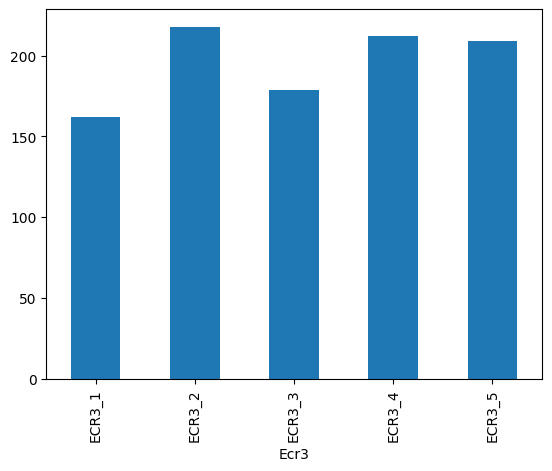

In [19]:
df.drop_duplicates(subset = 'Articolo').groupby('Ecr3')['Giacenza Pezzi Volume [m3]'].sum().plot.bar()

In [20]:
gene_space = [0,1]
num_genes = len(df['Ecr3'].dropna().unique())
sol_per_pop = 100
penalty_factor = 1
M = 500000

stock = df.drop_duplicates(subset = 'Articolo').groupby('Ecr3')['Giacenza Pezzi Volume [m3]'].sum().values
# Define DC capacities (m3)
#capacity_A = 19800 * 0.37 #25000
#capacity_B =  12720 * 0.37 #6800

capacity_A = df.drop_duplicates(subset = 'Articolo').groupby('Ecr1')['Giacenza Pezzi Volume [m3]'].sum().sum()*0.65
capacity_B = df.drop_duplicates(subset = 'Articolo').groupby('Ecr1')['Giacenza Pezzi Volume [m3]'].sum().sum()*0.45

#stock = np.zeros(num_genes)
#capacity_A = 999999999999999
#capacity_B = 999999999999999

In [21]:
stock.sum(),capacity_A,capacity_B

(978.798025, 636.21871625, 440.45911125000003)

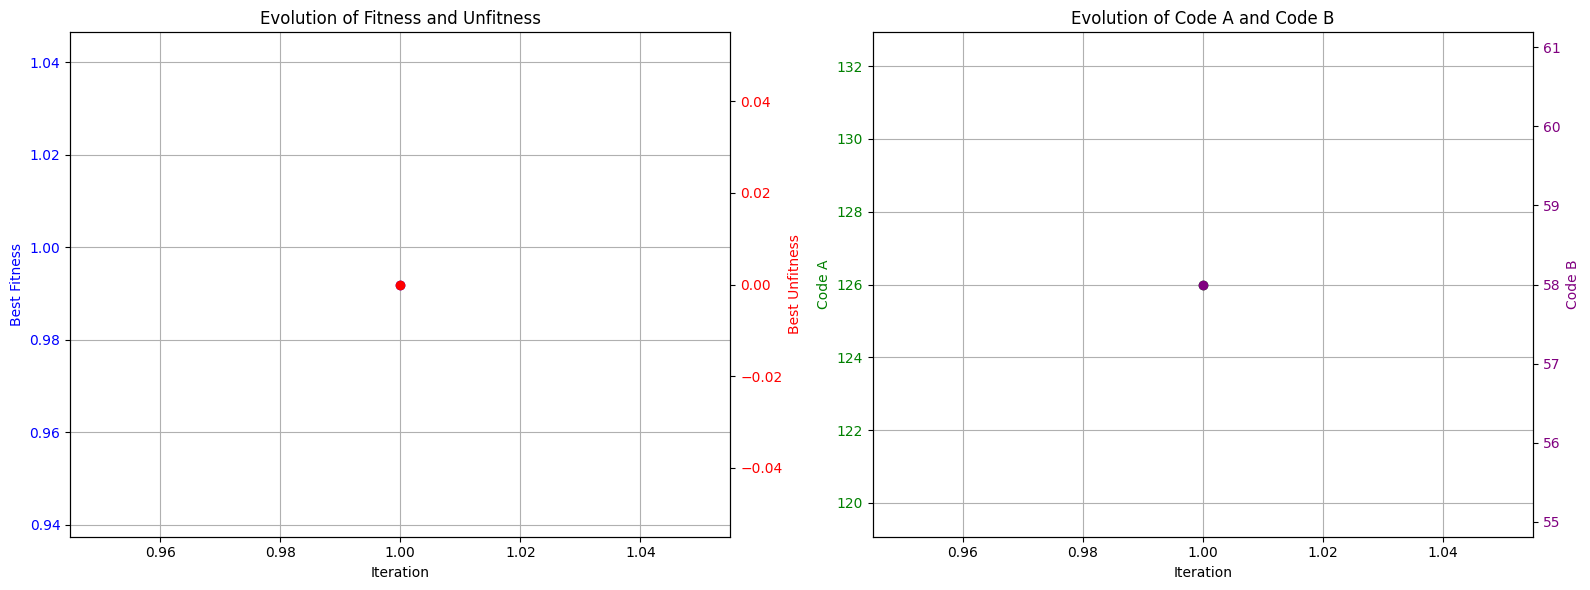

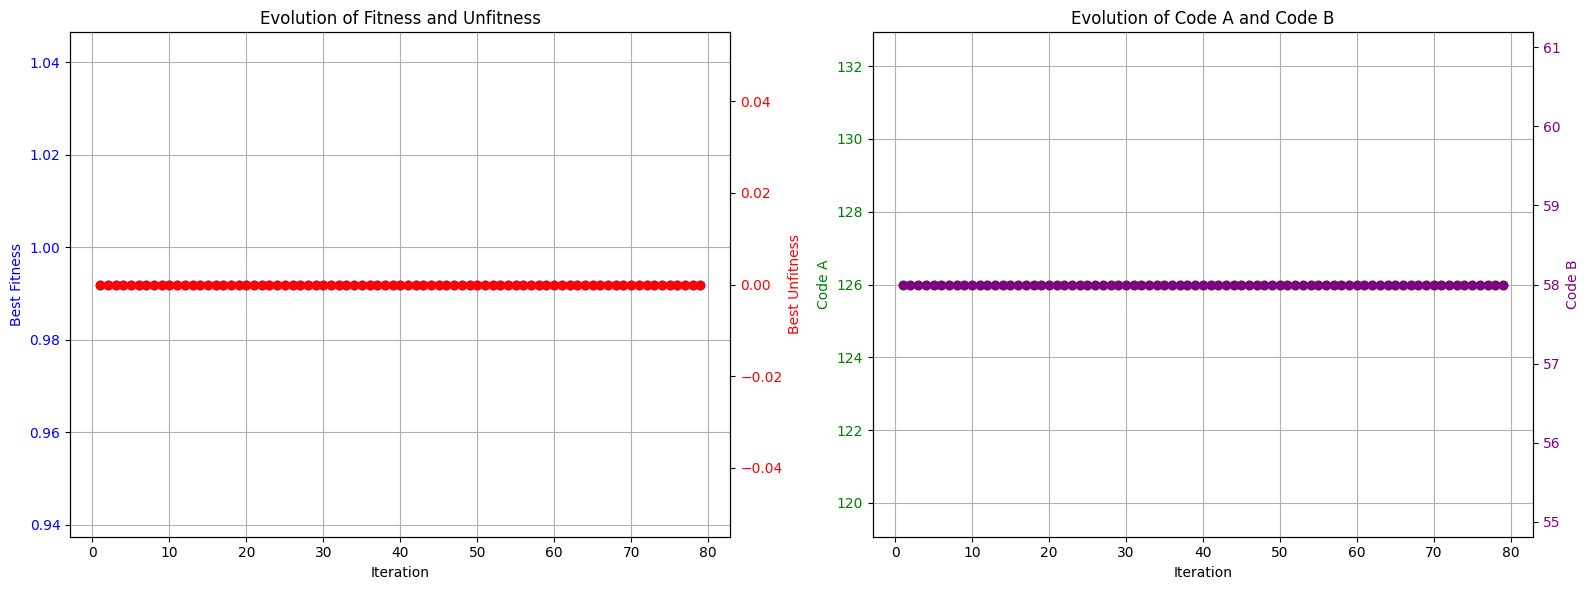

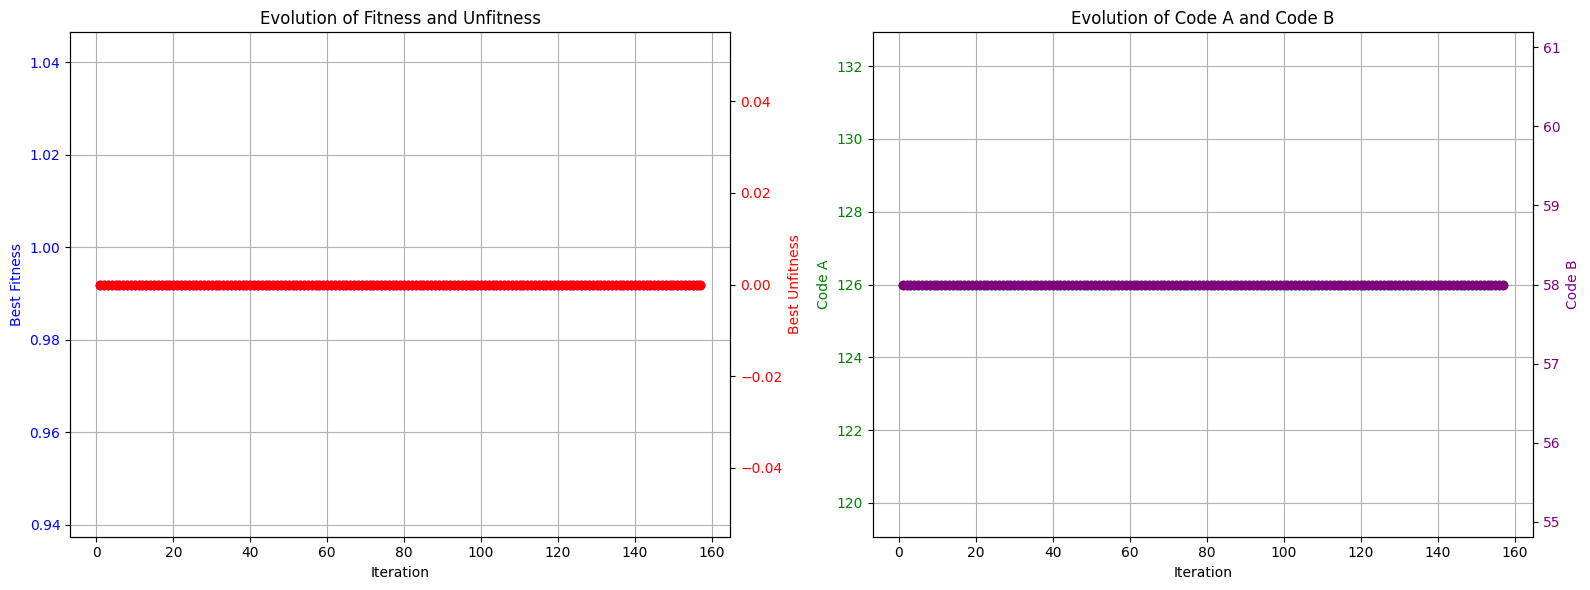

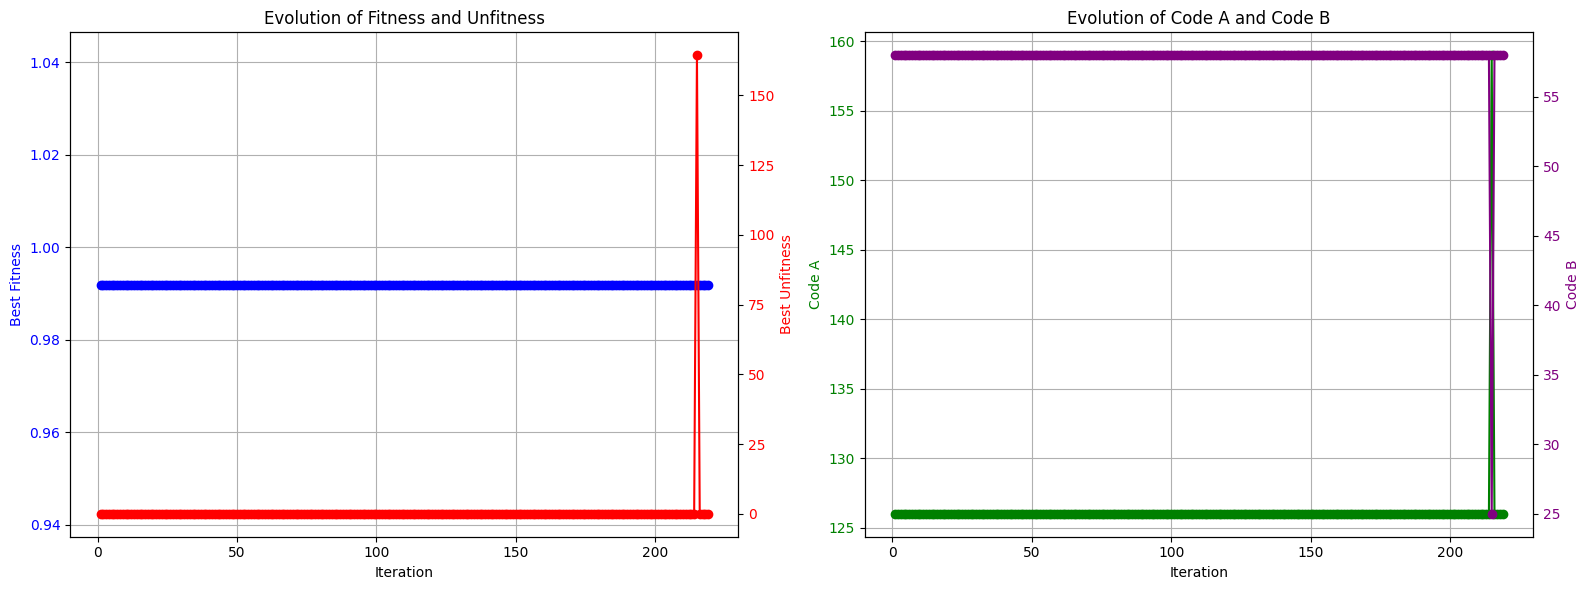

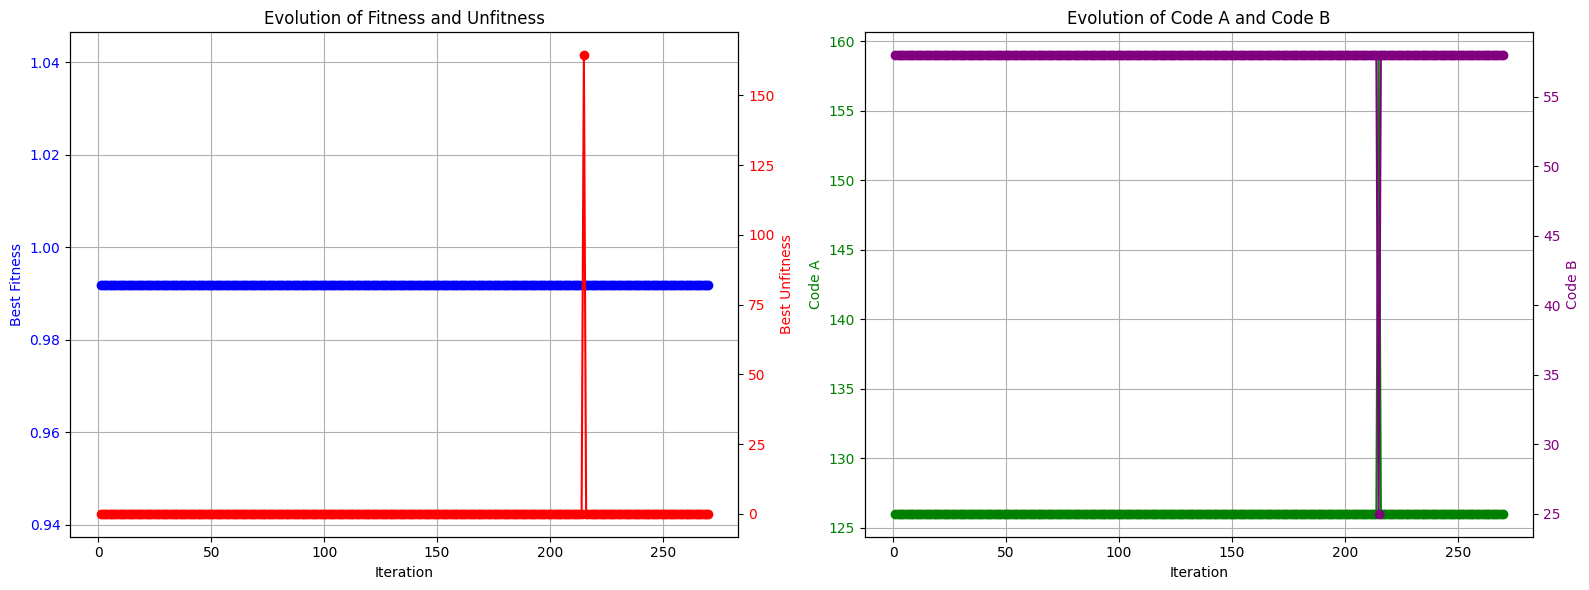

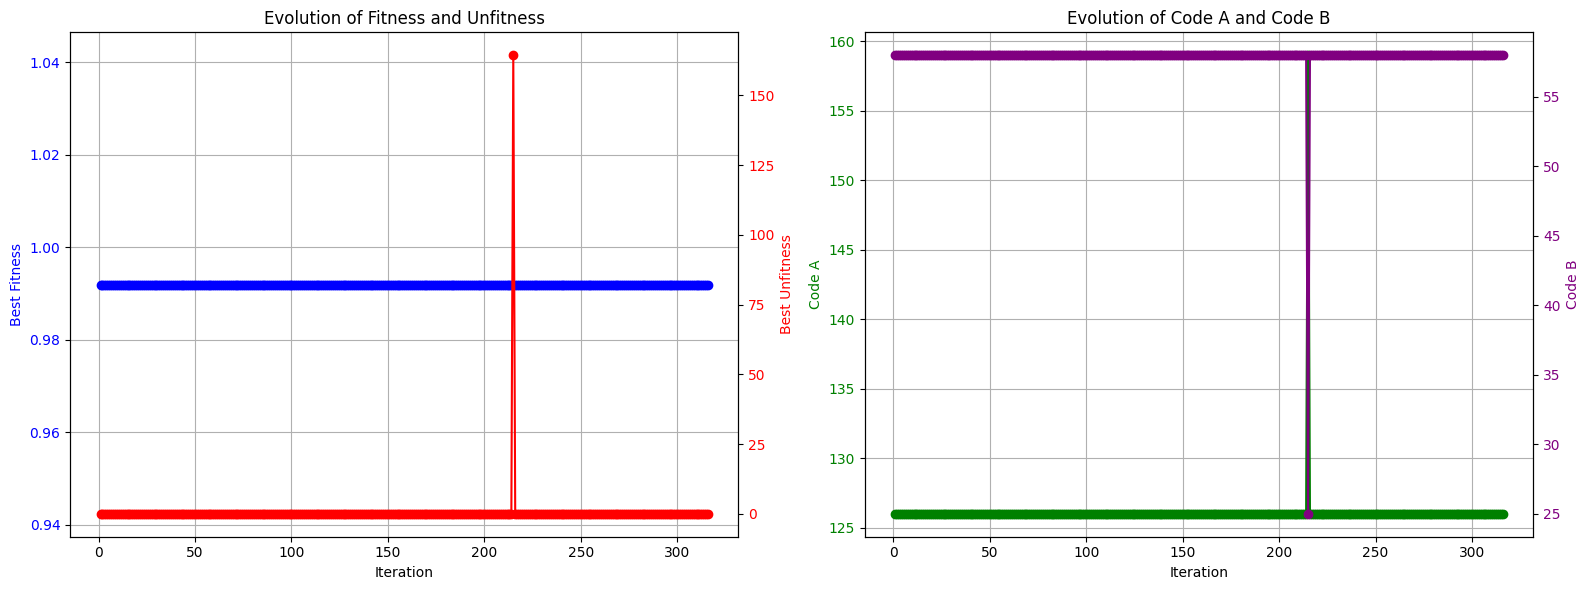

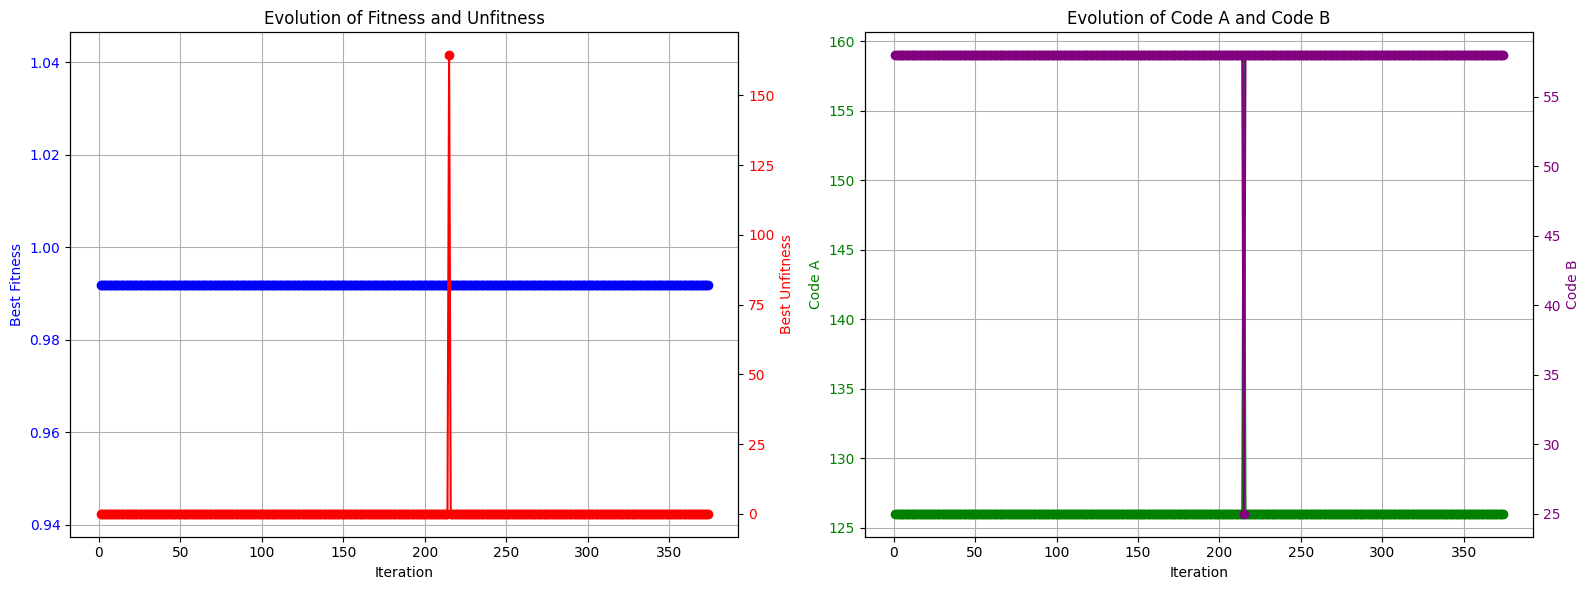

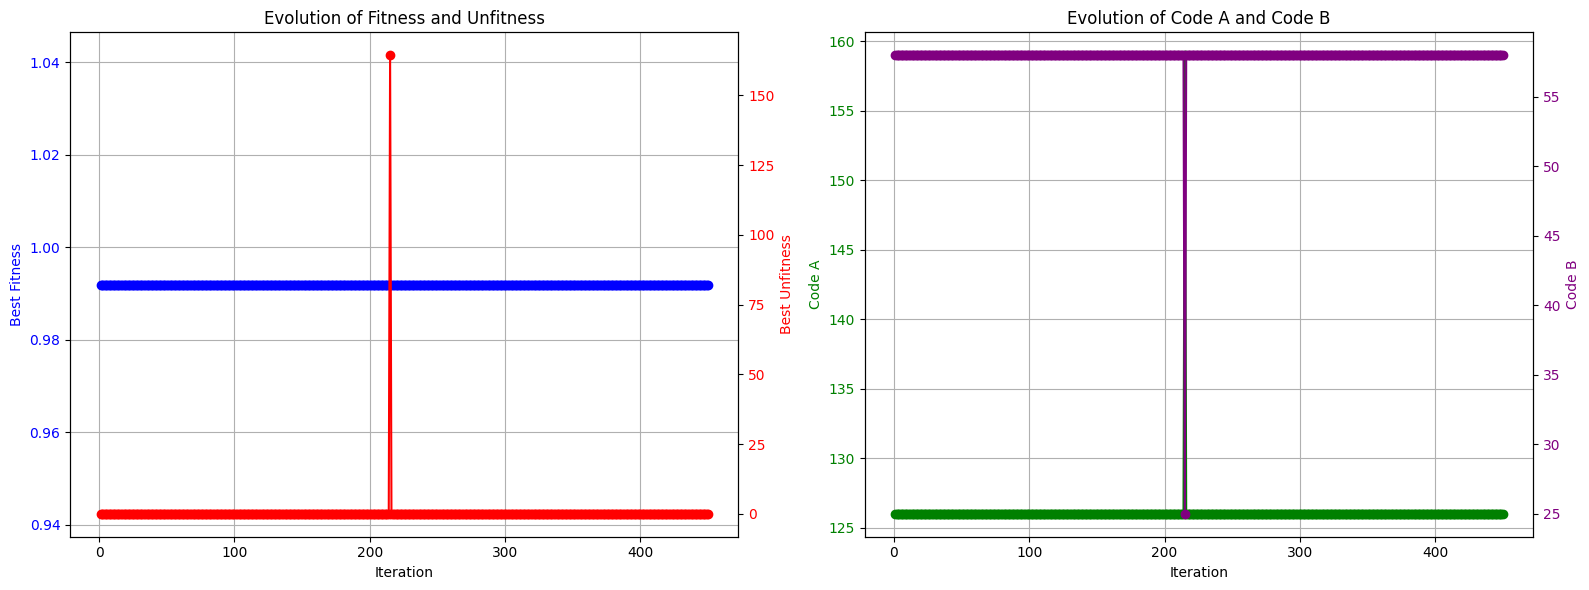

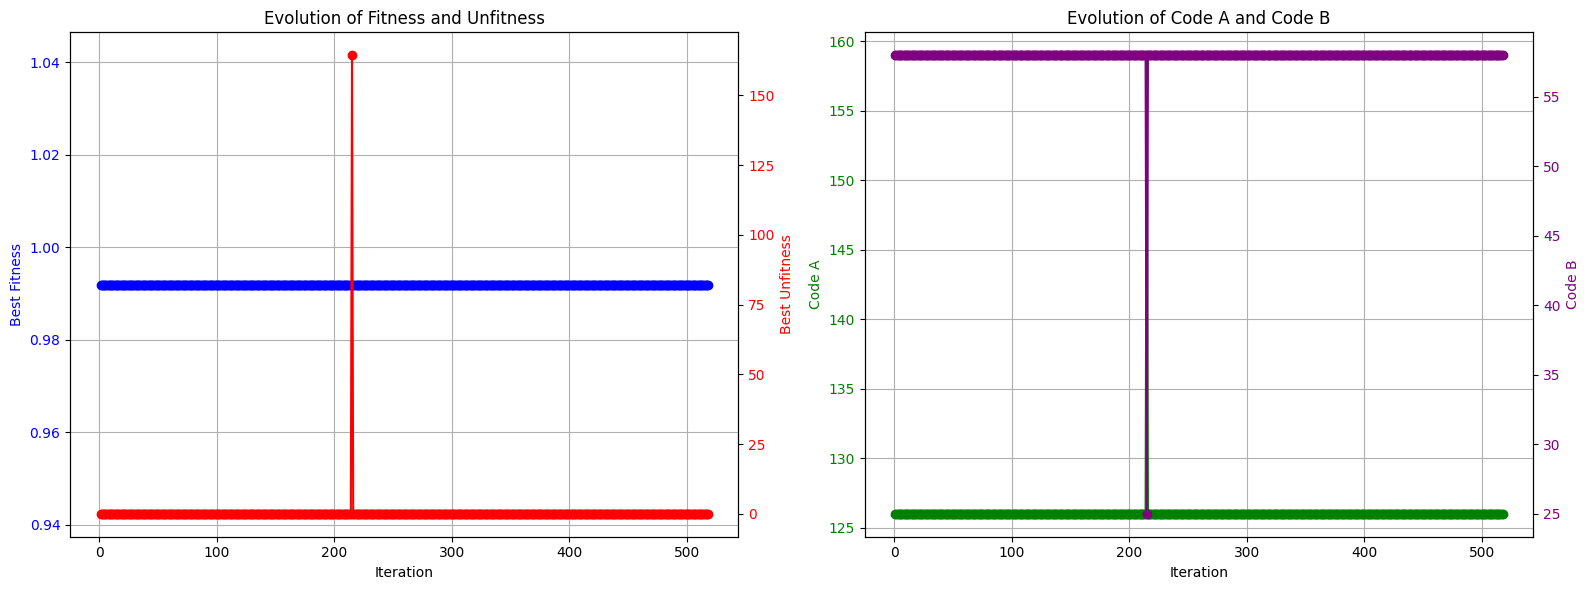

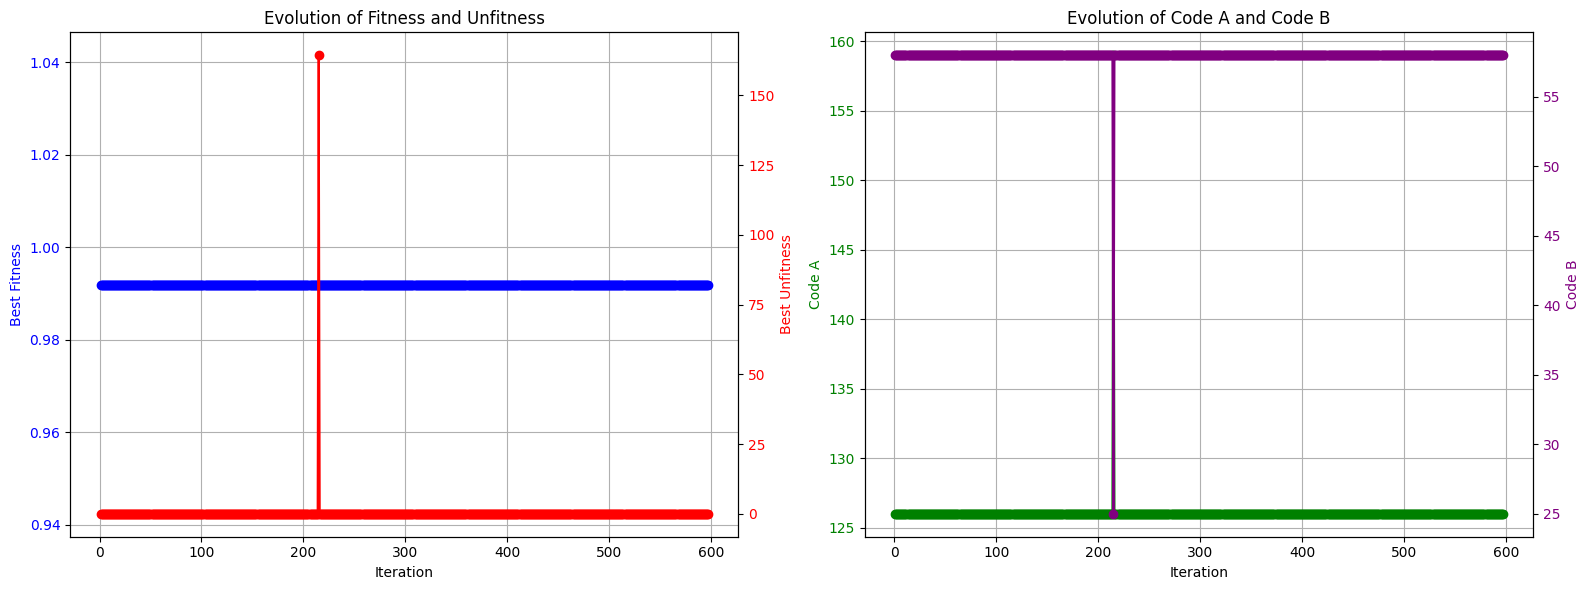

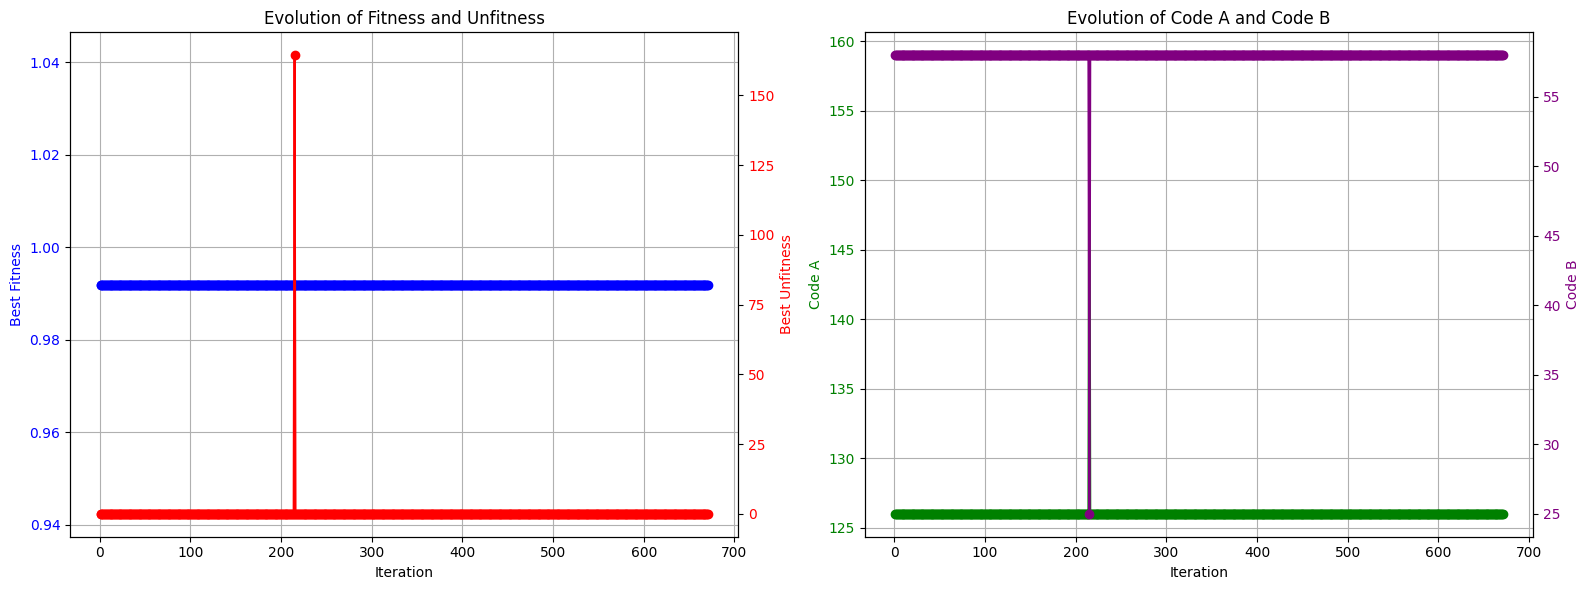

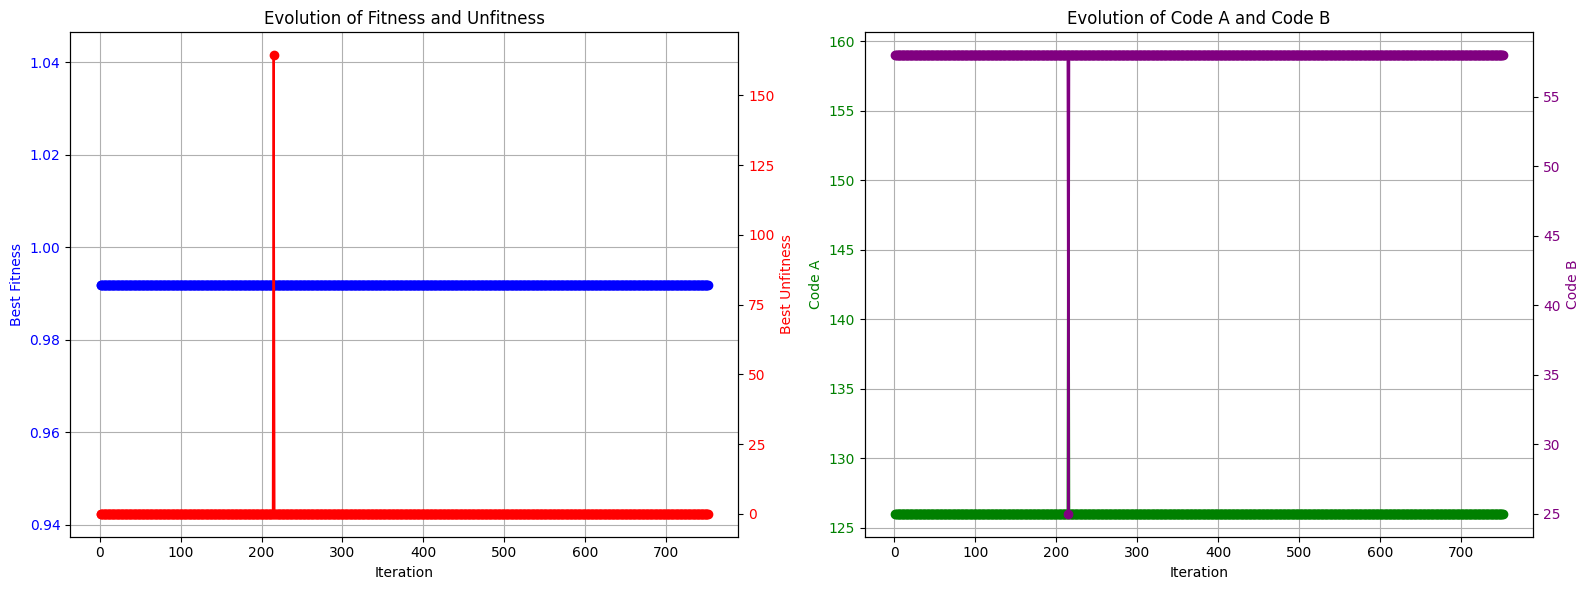

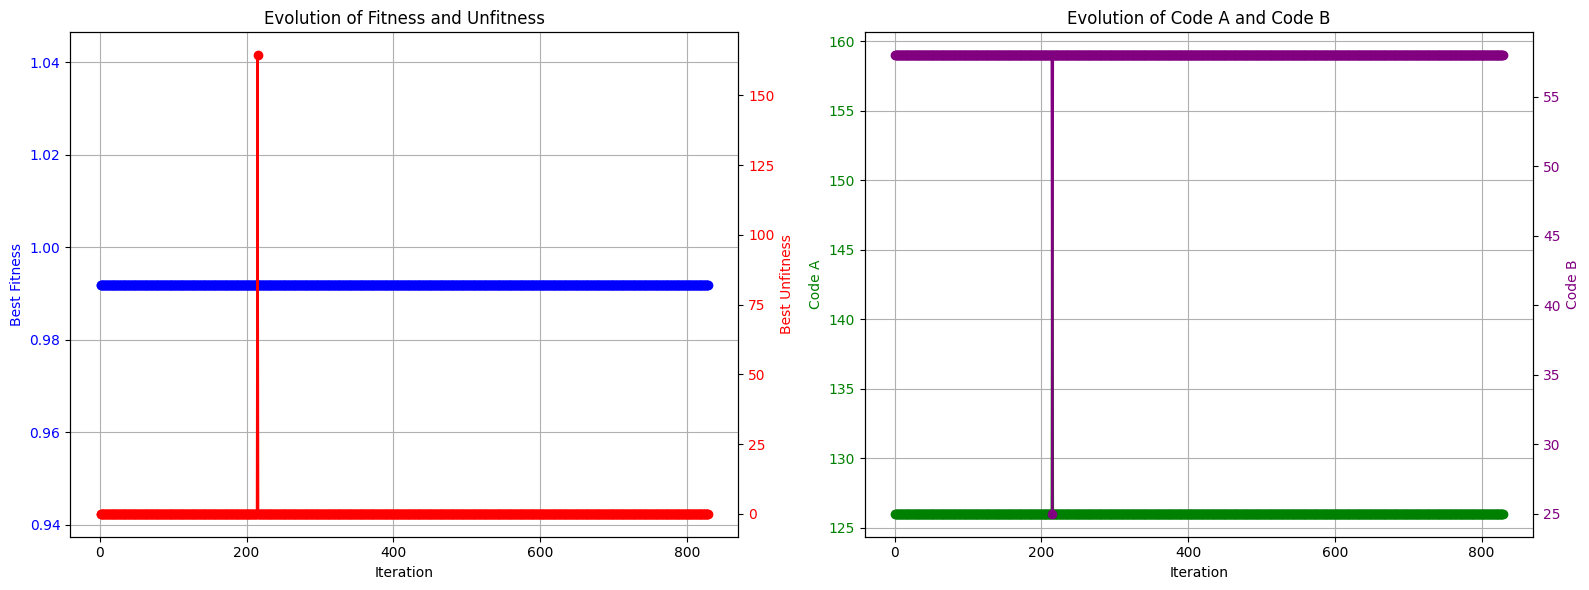

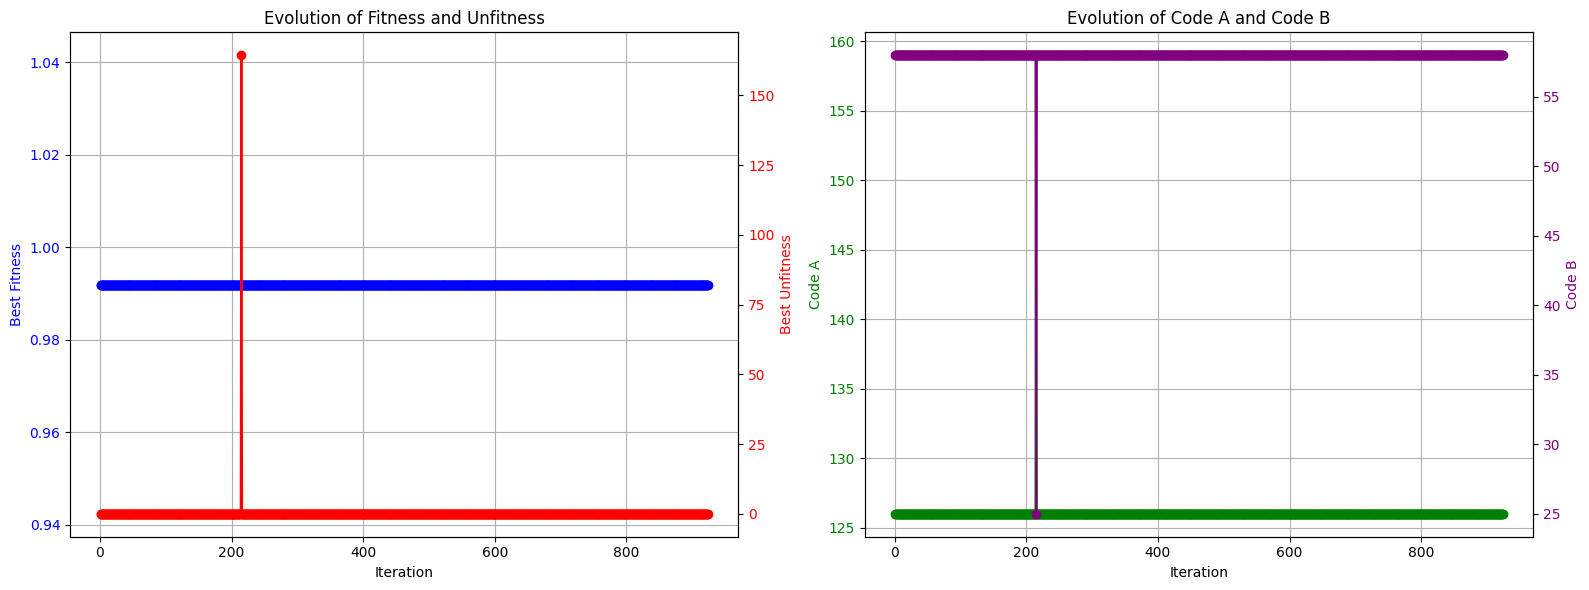

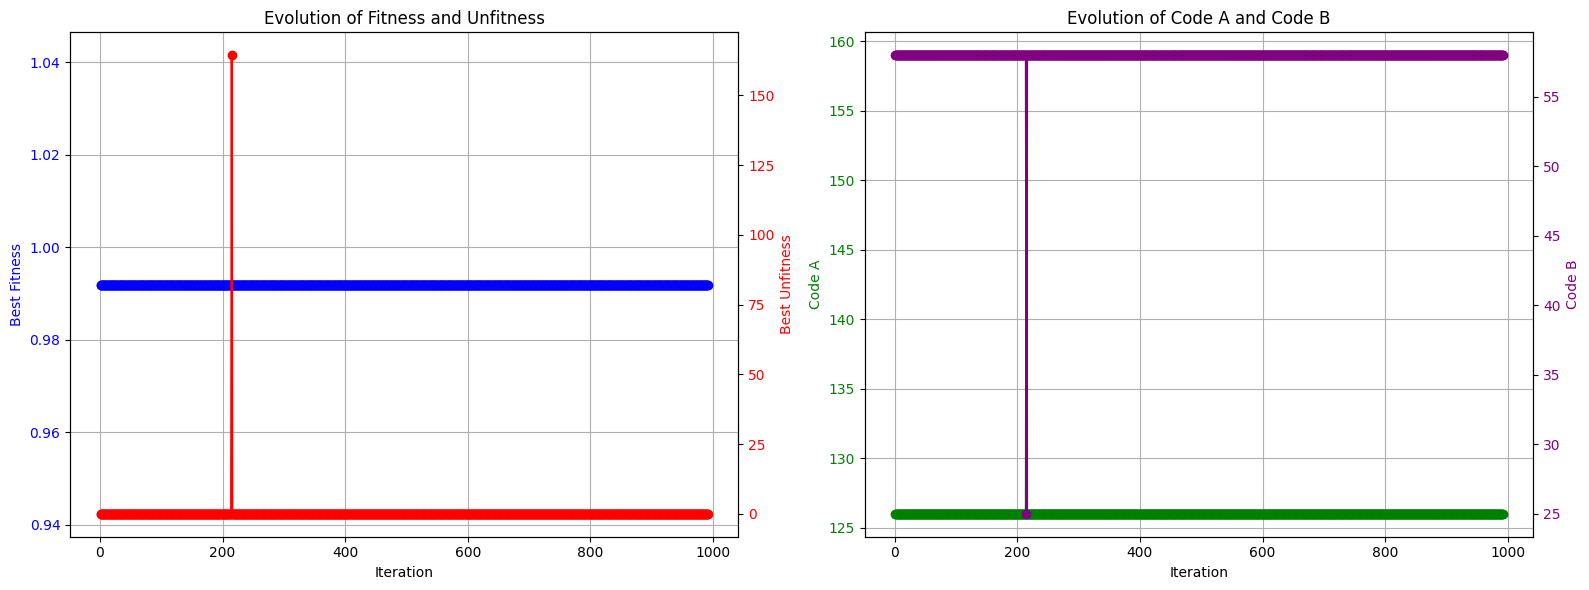

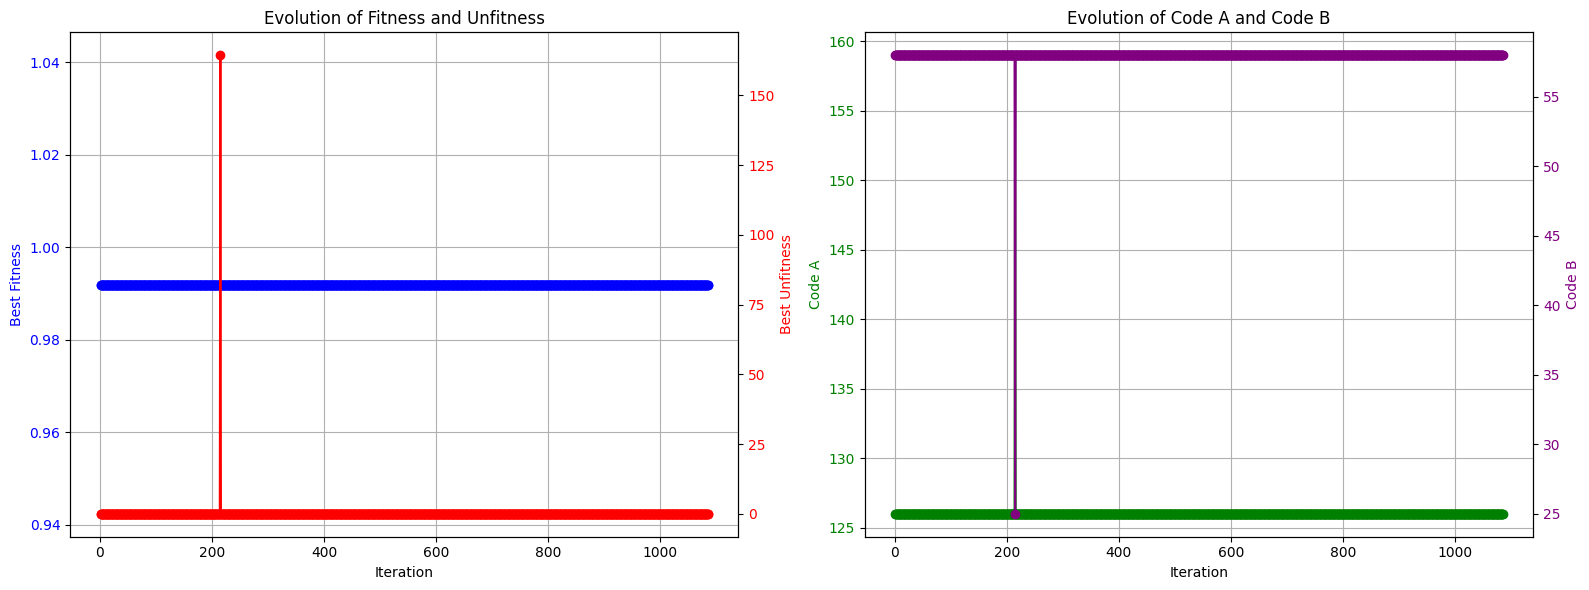

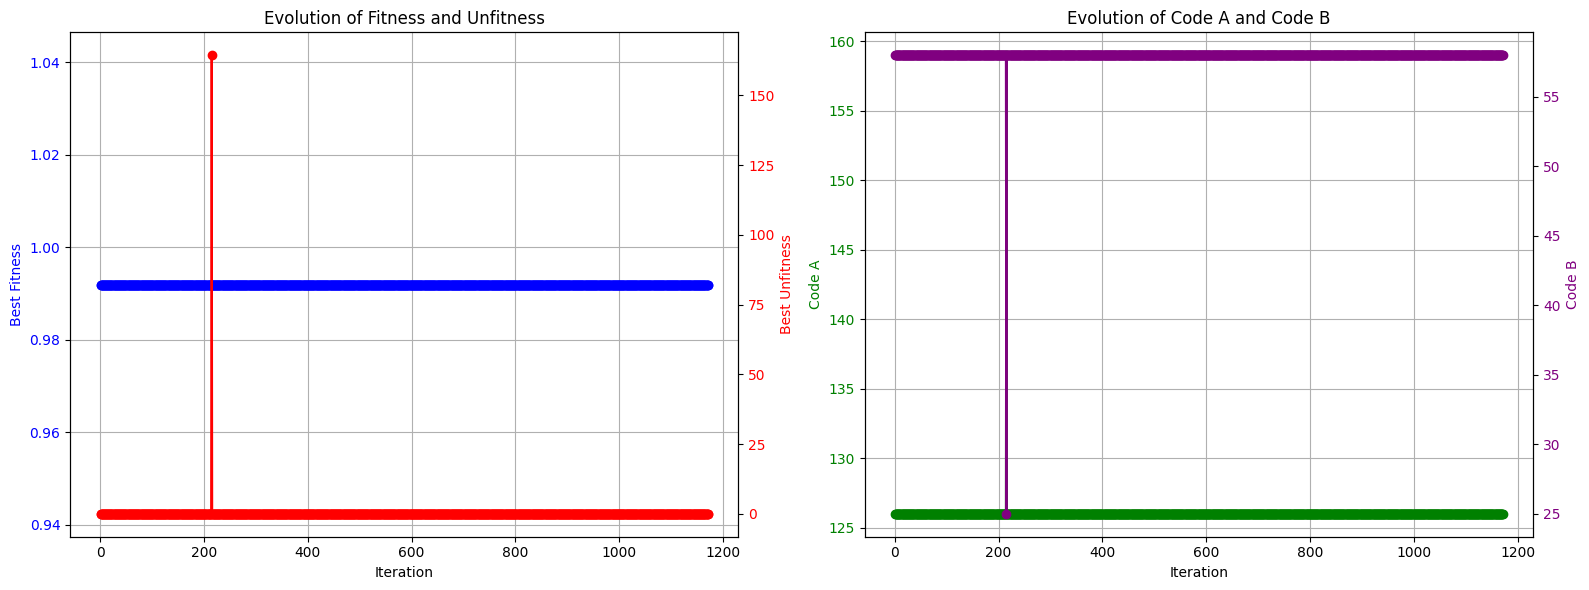

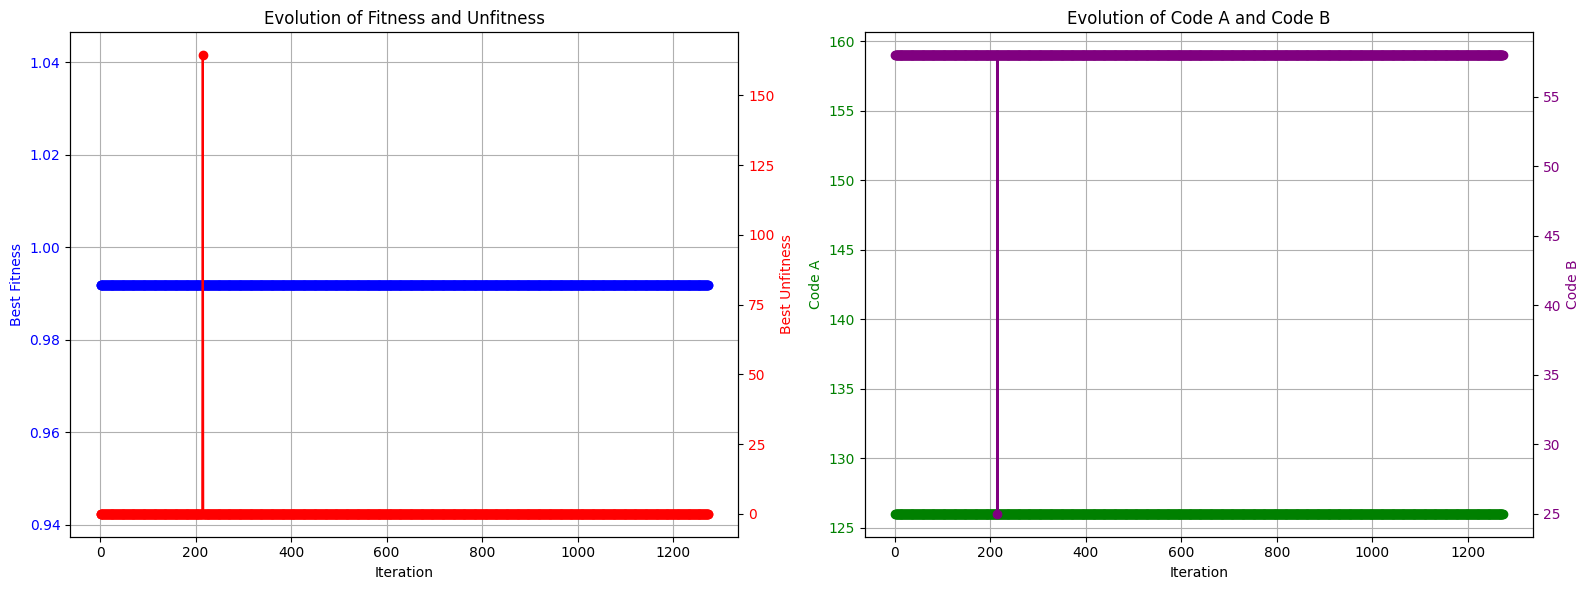

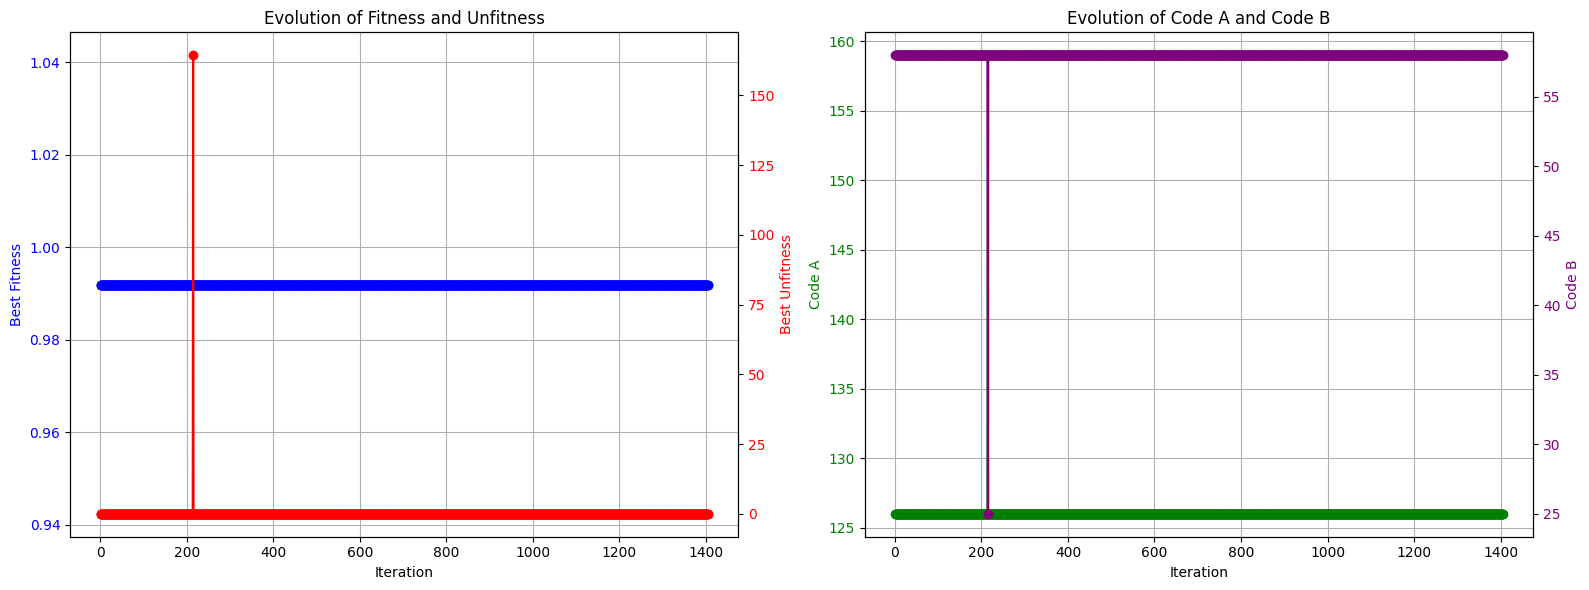

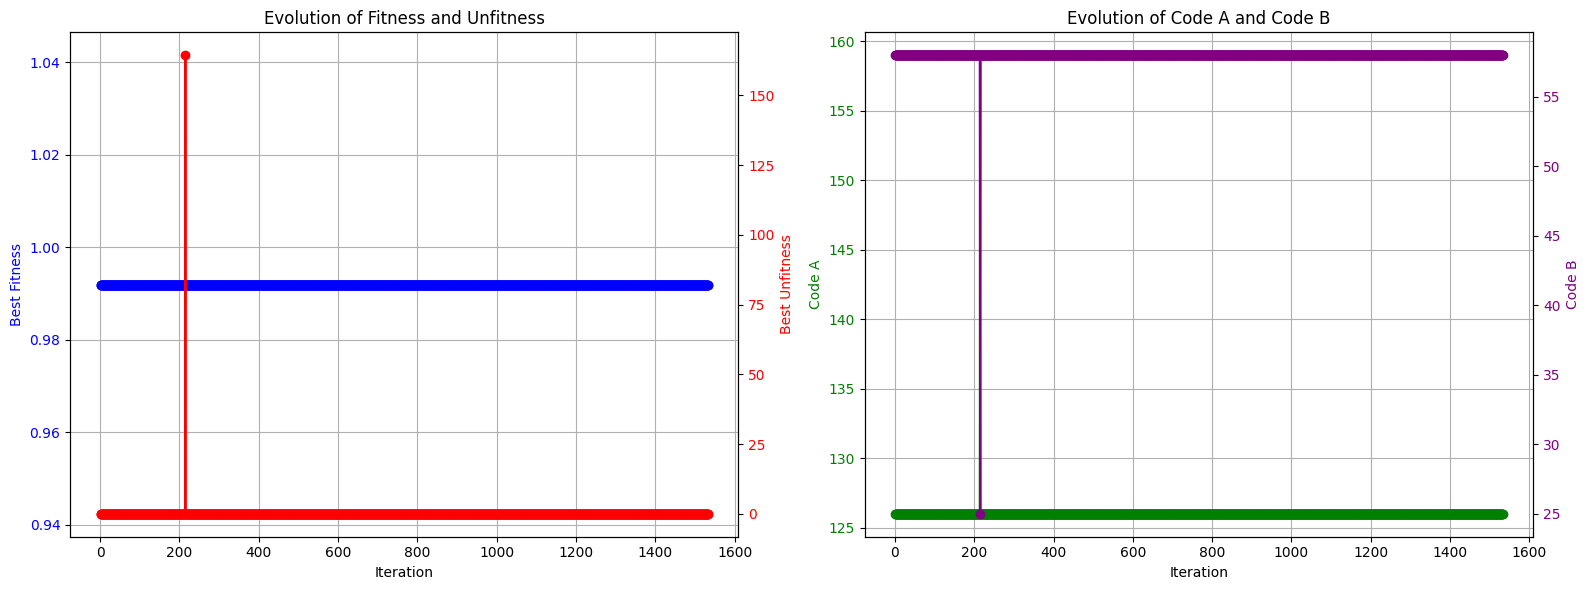

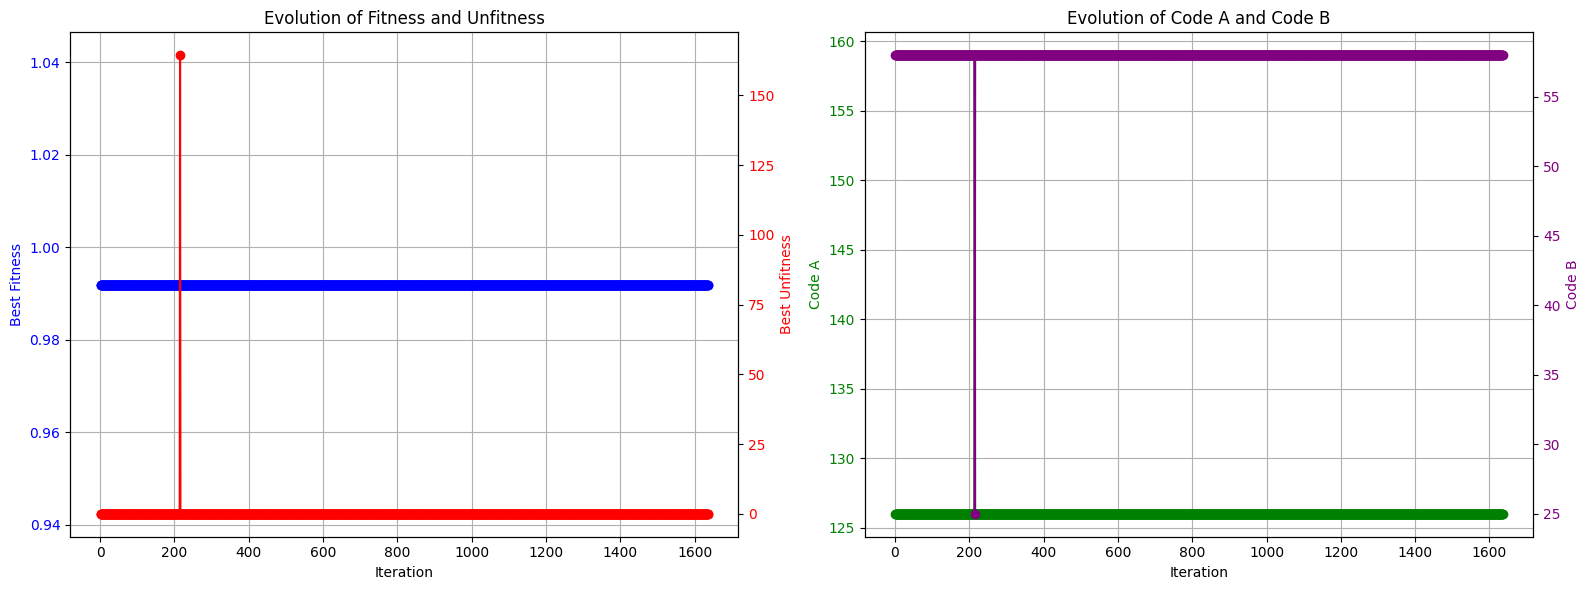

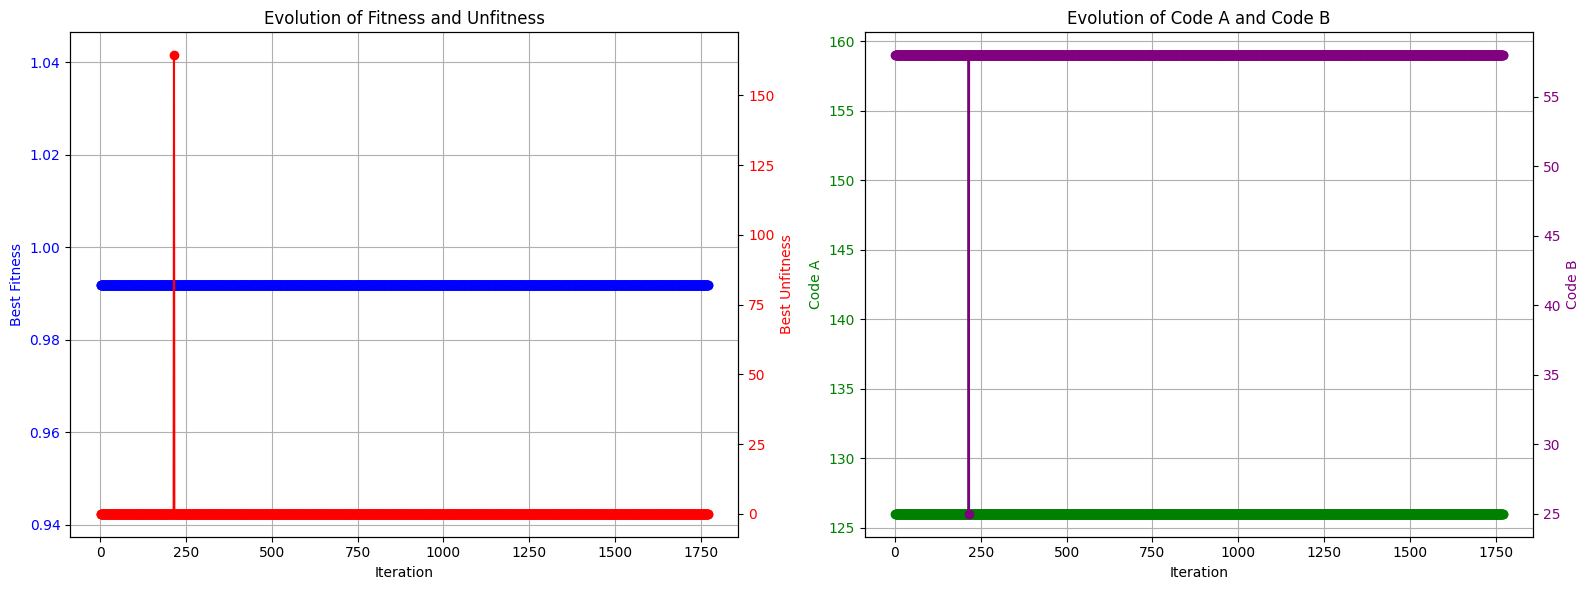

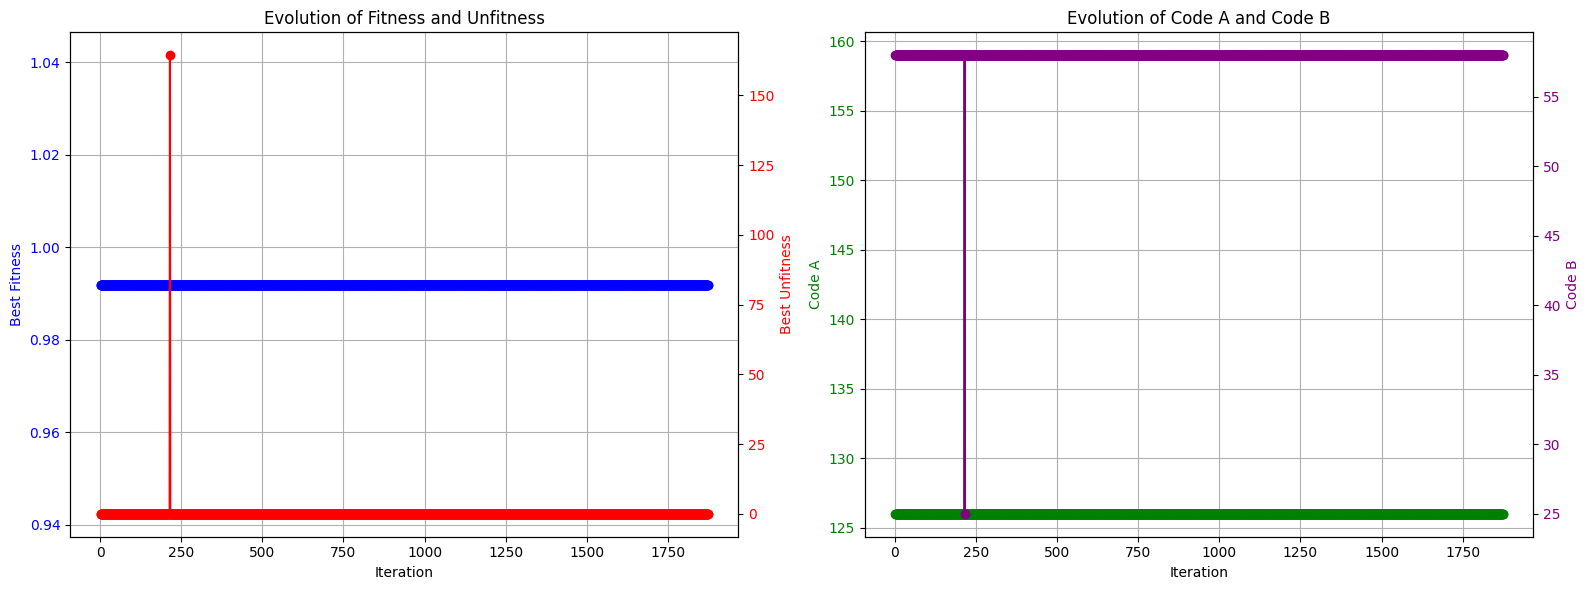

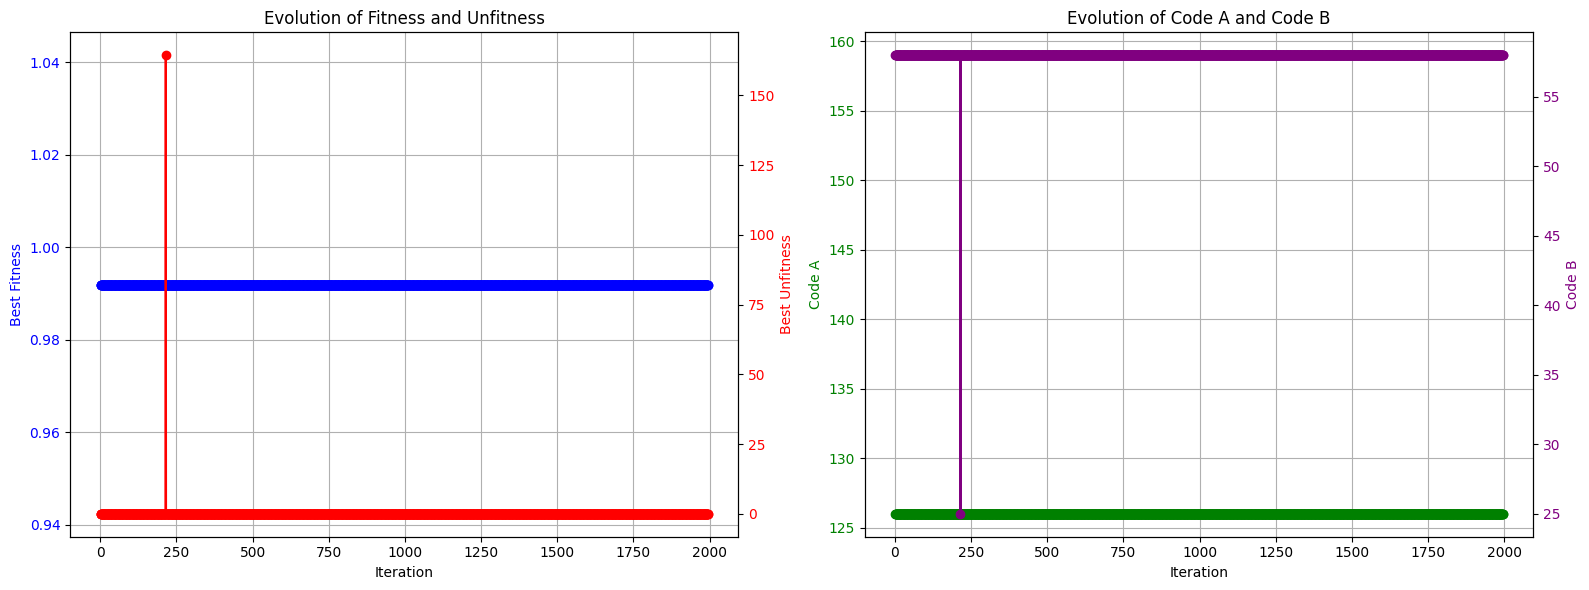

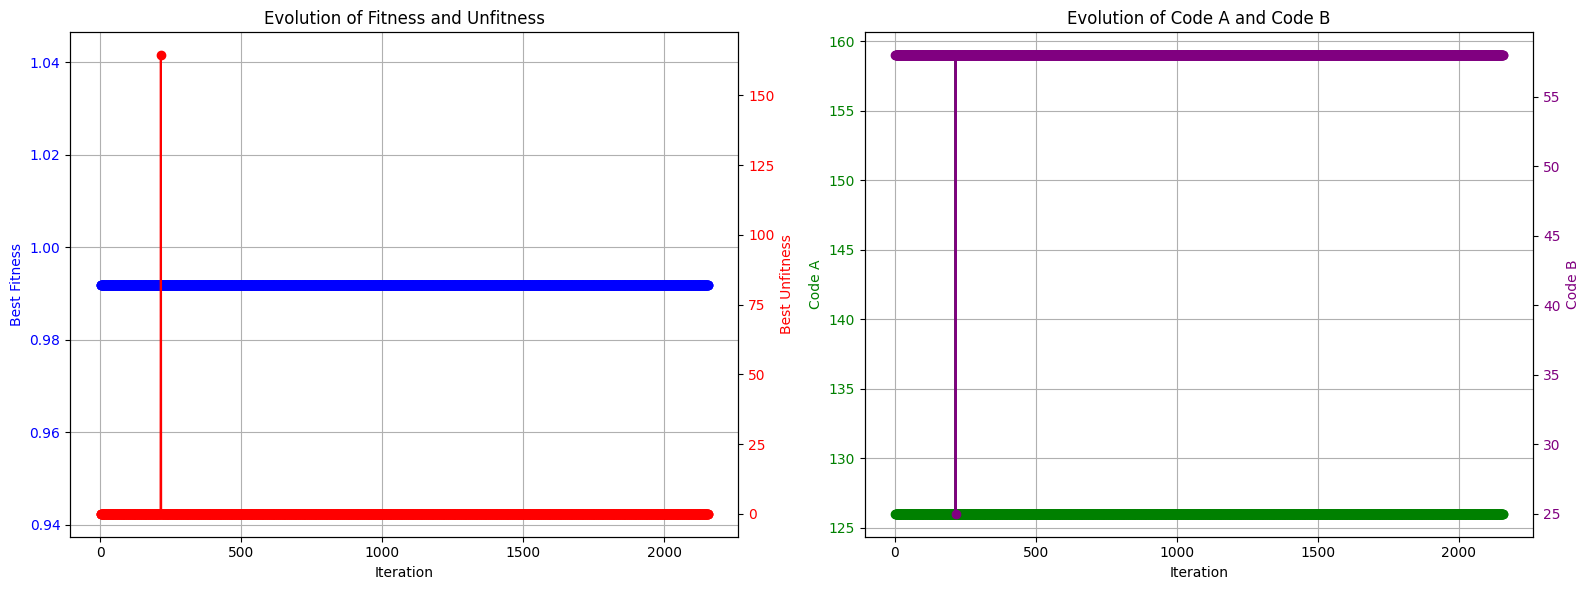

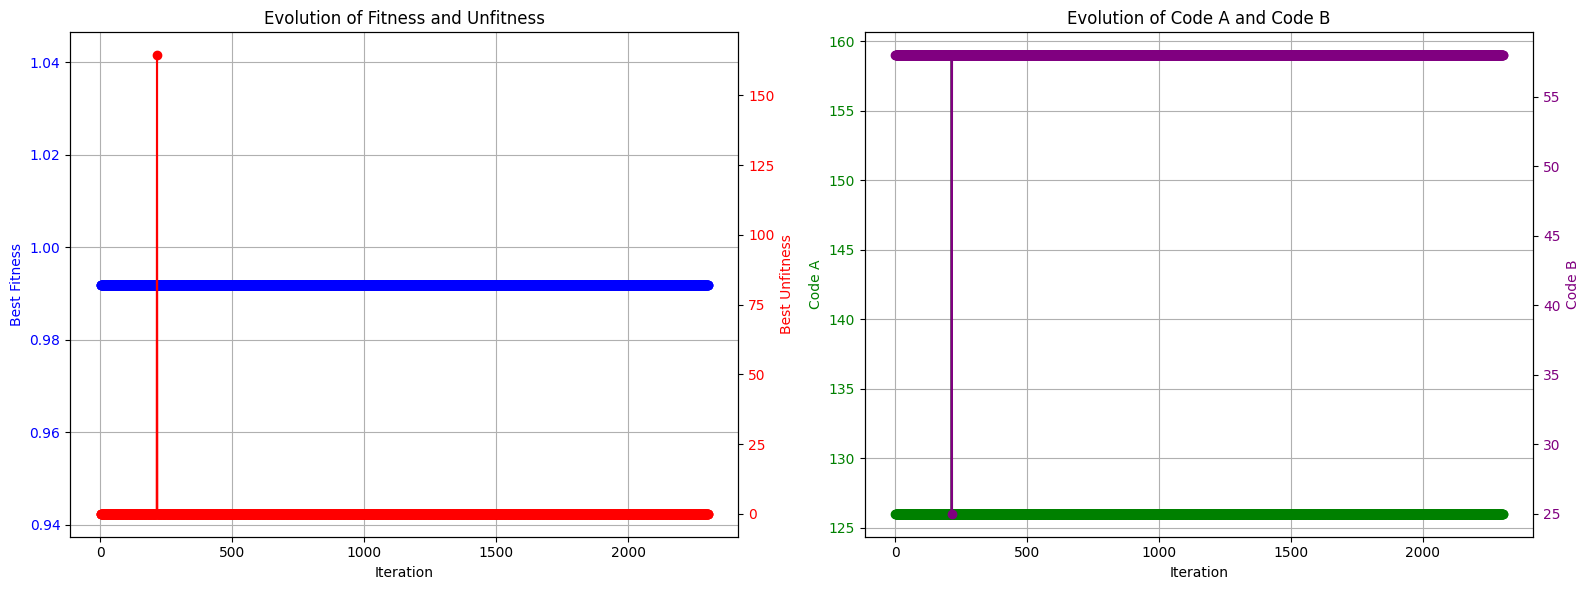

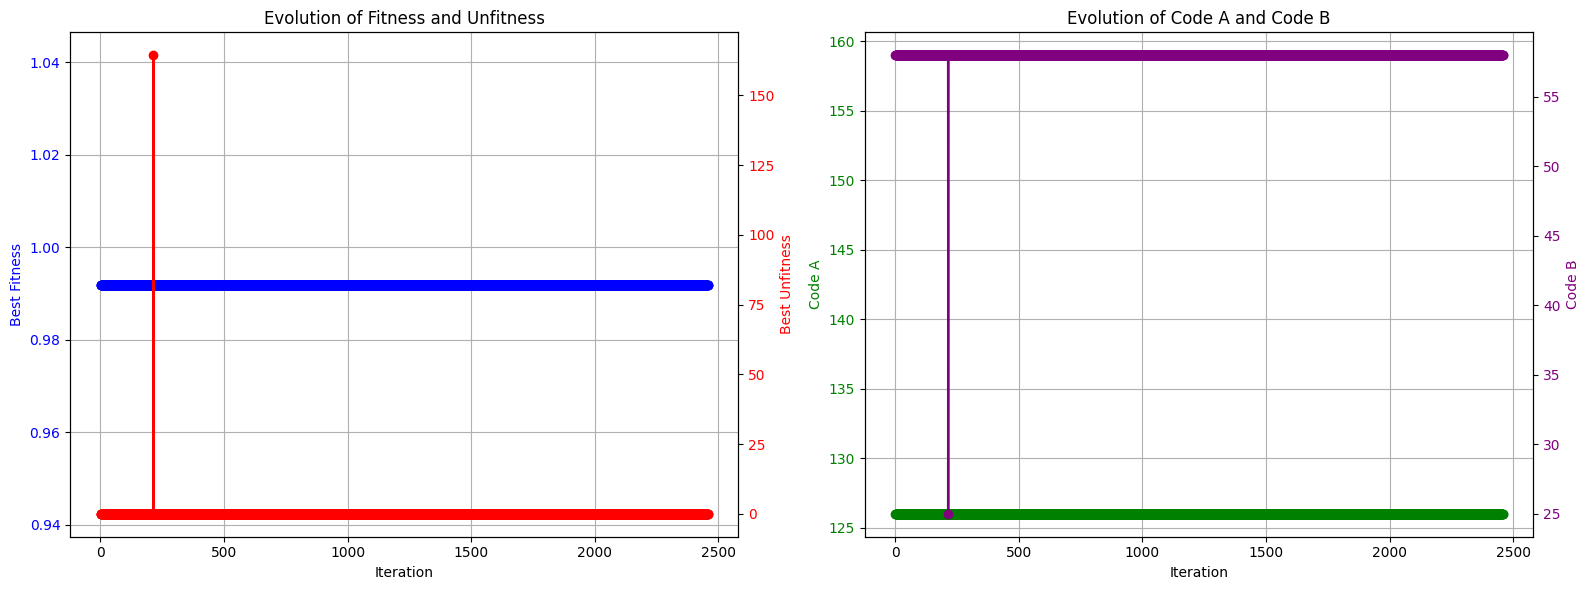

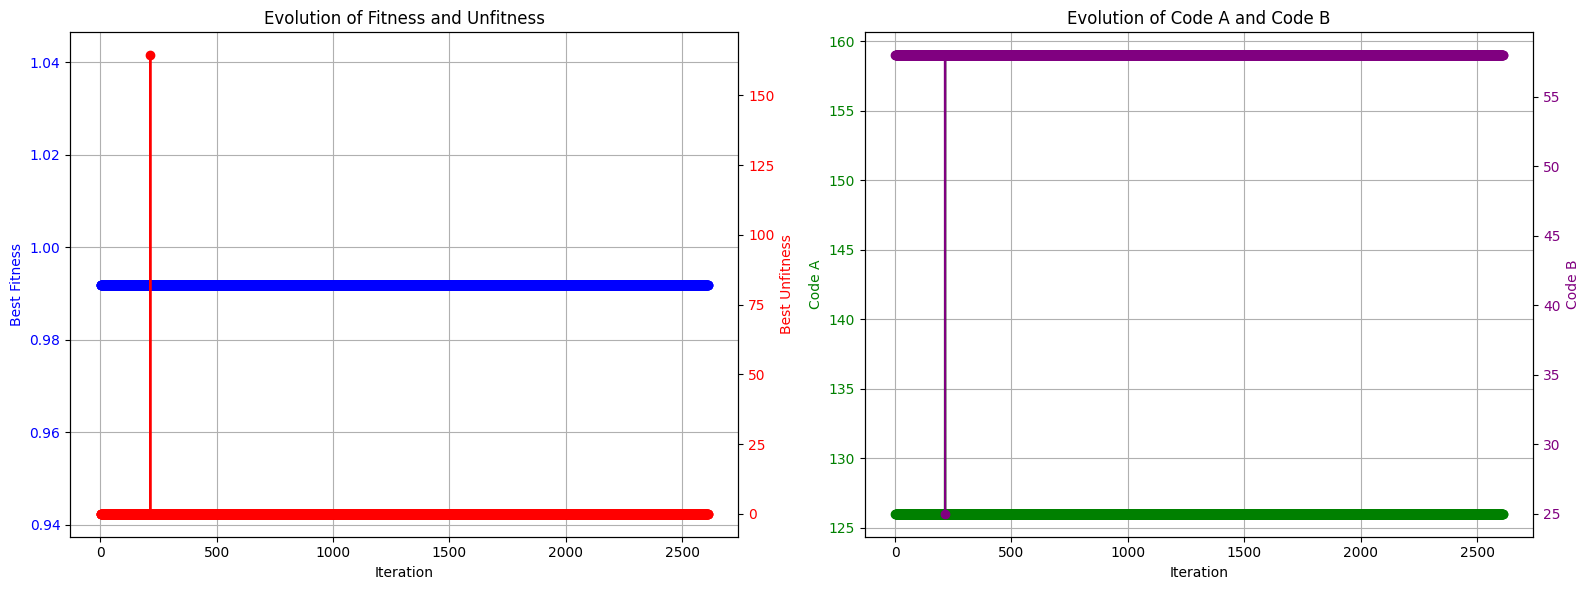

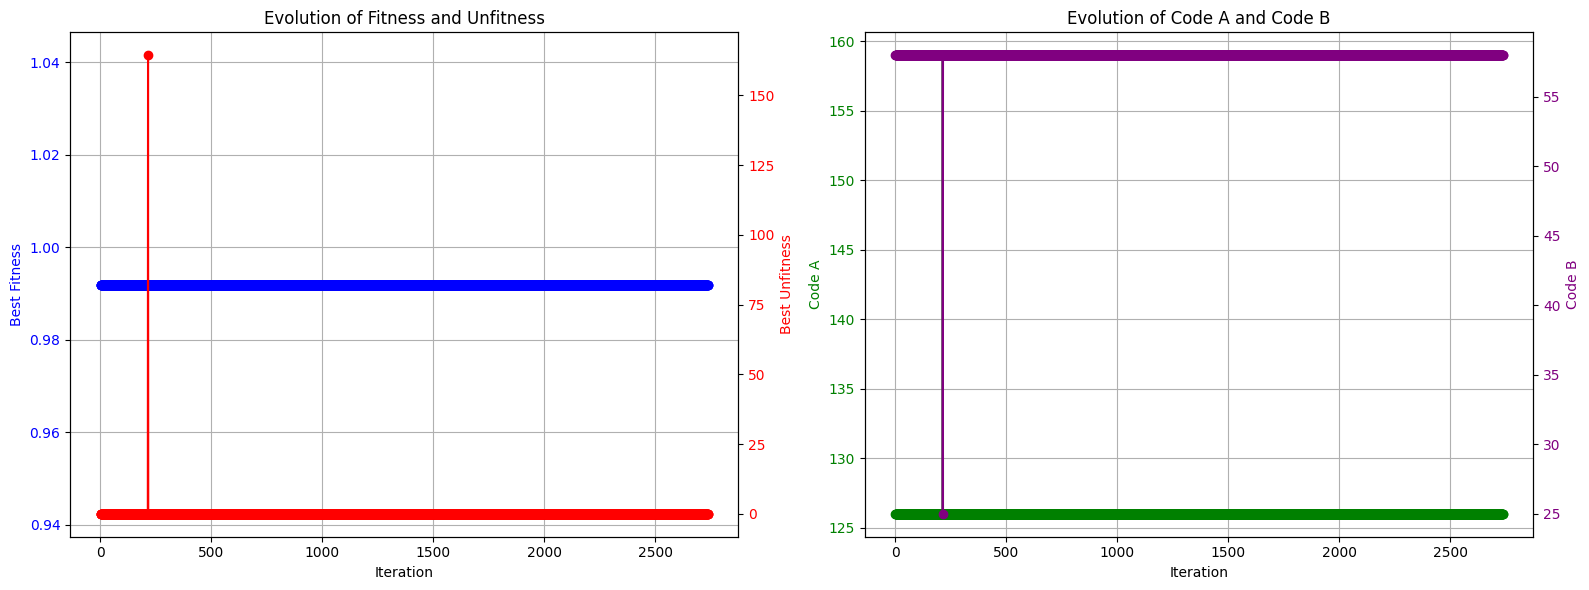

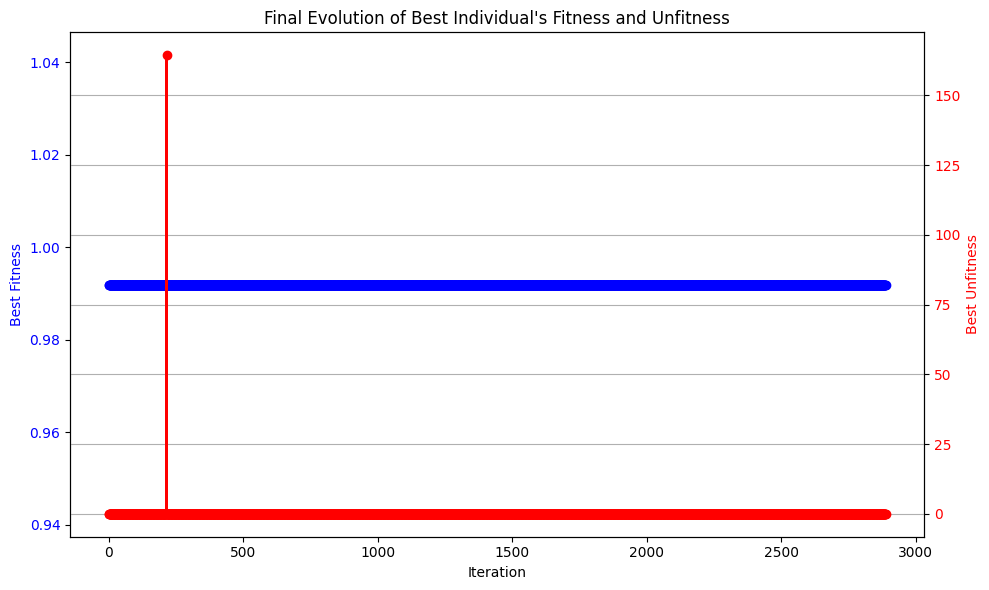

In [22]:
# Run the Genetic Algorithm.
best_population, best_fitness_values, best_unfitness_values, comp_time = main(
    day=None,
    gene_space=gene_space,
    num_genes=num_genes,
    sol_per_pop=sol_per_pop,
    df=df,
    stock=stock,
    capacity_A=capacity_A,
    capacity_B=capacity_B,
    M=M,
    penalty_factor=penalty_factor
)

In [23]:
print("Global Best Individual:")
print(best_individual)
print("Global Fitness Values:")
print(best_individual_fitness)
print("Global Unfitness Values:")
print(best_individual_unfitness)
#print("Total Computational Time (sec):", comp_time)

Global Best Individual:
[0 1 1 0 0]
Global Fitness Values:
0.9939393939393939
Global Unfitness Values:
0


# STATISTICS

In [24]:
# Set a custom column width
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.max_columns', None)  # or set a number like 1000

In [25]:
df_allocation = pd.DataFrame({'Ecr3': df['Ecr3'].dropna().unique()})
df_allocation['Warehouse'] = best_individual
df_allocation

,Ecr3,Warehouse
0,ECR3_3,0
1,ECR3_2,1
2,ECR3_4,1
3,ECR3_5,0
4,ECR3_1,0


In [26]:
df = pd.merge(df, df_allocation, on='Ecr3', how='left')
df['Warehouse'] = df['Warehouse'].replace({0: 'A', 1: 'B'})
df

,Num. Ordine,Mese-Giorno,Articolo,Pezzi evasi,Ecr1,Ecr2,Ecr3,Ecr4,Cliente,Percorso,Giacenza Pezzi Volume [m3],Volume evaso [m3],Warehouse
0,ORD_103,01-01,ART_67,8,ECR1_3,ECR2_2,ECR3_3,ECR4_3,CLI_75,PER_21,7.067544,0.547690,A
1,ORD_436,01-02,ART_104,5,ECR1_4,ECR2_4,ECR3_2,ECR4_1,CLI_64,PER_16,3.795272,0.991781,B
2,ORD_861,01-03,ART_174,2,ECR1_2,ECR2_4,ECR3_4,ECR4_4,CLI_81,PER_2,5.680234,0.664538,B
3,ORD_271,01-04,ART_24,6,ECR1_2,ECR2_5,ECR3_3,ECR4_1,CLI_51,PER_2,4.561796,0.200047,A
4,ORD_107,01-05,ART_114,5,ECR1_5,ECR2_1,ECR3_3,ECR4_5,CLI_53,PER_23,6.753355,0.045916,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,ORD_18,05-11,ART_184,9,ECR1_3,ECR2_4,ECR3_3,ECR4_2,CLI_29,PER_15,7.180346,0.781138,A
496,ORD_793,05-12,ART_145,7,ECR1_1,ECR2_2,ECR3_5,ECR4_4,CLI_59,PER_2,2.890999,0.791672,A
497,ORD_735,05-13,ART_74,9,ECR1_4,ECR2_5,ECR3_3,ECR4_3,CLI_98,PER_30,3.701715,0.602867,A
498,ORD_566,05-14,ART_17,6,ECR1_2,ECR2_4,ECR3_3,ECR4_1,CLI_17,PER_21,1.988187,0.512127,A


In [27]:
df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [],
        'Magazzino B':[],
        
        'Codici in A':[],
        'Codici in B':[],
        
        'Stock [m3] in A':[],
        'Stock [m3] in B':[],
        
        '% Ordini completati in AB':[],
        '% Ordini completati in A':[], 
        '% Ordini completati in B':[],

        'Vol[m3] Ordini completati in A':[], 
        'Vol[m3] Ordini completati in B':[],
        'Vol[m3] Ordini completati in AB':[],
        'Vol[m3] Ordini completati in AB (A)':[],
        'Vol[m3] Ordini completati in AB (B)':[],
        
        '% Rotte completate in AB' :[],
        '% Rotte completate in A' :[],
        '% Rotte completate in B' :[],

        'Vol[m3] Rotte completati in A' :[],
        'Vol[m3] Rotte completati in B' :[],
        'Vol[m3] Rotte completati in AB' :[],
        'Vol[m3] Rotte completati in AB (A)' :[],
        'Vol[m3] Rotte completati in AB (B)' :[],

    }
)
df_results

,Magazzino A,Magazzino B,Codici in A,Codici in B,Stock [m3] in A,Stock [m3] in B,% Ordini completati in AB,% Ordini completati in A,% Ordini completati in B,Vol[m3] Ordini completati in A,Vol[m3] Ordini completati in B,Vol[m3] Ordini completati in AB,Vol[m3] Ordini completati in AB (A),Vol[m3] Ordini completati in AB (B),% Rotte completate in AB,% Rotte completate in A,% Rotte completate in B,Vol[m3] Rotte completati in A,Vol[m3] Rotte completati in B,Vol[m3] Rotte completati in AB,Vol[m3] Rotte completati in AB (A),Vol[m3] Rotte completati in AB (B)


In [28]:
assignment_A = df.groupby('Warehouse')['Ecr3'].unique().get('A', 0)
assignment_B = df.groupby('Warehouse')['Ecr3'].unique().get('B', 0)

code_A = df.groupby('Warehouse')['Articolo'].nunique().get('A', 0)
code_B = df.groupby('Warehouse')['Articolo'].nunique().get('B', 0)
# print('Article division', article_division)

#Order analysis
order_grouped_df = df.groupby(['Mese-Giorno','Num. Ordine']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

order_movment_A = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100
order_movment_B = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(order_grouped_df) * 100
order_movment_AB = len(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(order_grouped_df) * 100

order_vol_A = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
order_vol_B = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
order_vol_AB = order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

AB_order_list = list(order_grouped_df[order_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & order_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Num. Ordine'])
df_AB_order_volume = df.groupby(['Num. Ordine','Warehouse'])[['Volume evaso [m3]']].sum().reset_index()
df_AB_order_volume = df_AB_order_volume[df_AB_order_volume['Num. Ordine'].isin(AB_order_list)].groupby('Warehouse')['Volume evaso [m3]'].sum()

#Route analysis
route_grouped_df = df.groupby(['Mese-Giorno','Percorso']).agg({
    'Warehouse': lambda x: list(x.unique()),  # Stores unique warehouses as lists
    'Volume evaso [m3]': 'sum'  # Sums up volume
}).reset_index()

route_movment_A = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100
route_movment_B = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]) / len(route_grouped_df) * 100
route_movment_AB = len(route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]) / len(route_grouped_df) * 100

route_vol_A = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum() 
route_vol_B = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'") & ~route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'")]['Volume evaso [m3]'].sum() 
route_vol_AB = route_grouped_df[route_grouped_df['Warehouse'].astype(str).str.contains(r"'A'") & route_grouped_df['Warehouse'].astype(str).str.contains(r"'B'")]['Volume evaso [m3]'].sum()

# Step 1: Extract valid routes containing both 'A' and 'B' in 'Warehouse'
AB_order_list = route_grouped_df[
    route_grouped_df['Warehouse'].astype(str).str.contains(r'A') & 
    route_grouped_df['Warehouse'].astype(str).str.contains(r'B')
][['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).tolist()

# Step 2: Compute total volume for each route
df_AB_route_volume = df.groupby(['Mese-Giorno', 'Percorso', 'Warehouse'])[['Volume evaso [m3]']].sum().reset_index()

# Step 3: Filter only the relevant routes and sum by Warehouse
df_AB_route_volume = df_AB_route_volume[
    df_AB_route_volume[['Mese-Giorno', 'Percorso']].apply(tuple, axis=1).isin(AB_order_list)
].groupby('Warehouse')['Volume evaso [m3]'].sum()


weighted_stock = df.groupby(['Articolo','Warehouse',])['Giacenza Pezzi Volume [m3]'].mean() * (df.groupby(['Articolo','Warehouse',])['Pezzi evasi'].sum() / df.groupby(['Articolo'])['Pezzi evasi'].sum())
stock_A = weighted_stock.groupby('Warehouse').sum().get('A', 0)
stock_B = weighted_stock.groupby('Warehouse').sum().get('B', 0)

df_results = pd.DataFrame.from_dict(
    {
        'Magazzino A': [assignment_A],
        'Magazzino B': [assignment_B],
        
        'Codici in A':[code_A],
        'Codici in B':[code_B],
        
        'Stock [m3] in A':[stock_A],
        'Stock [m3] in B':[stock_B],
        
        '% Ordini completati in AB':[order_movment_AB],
        '% Ordini completati in A':[order_movment_A],
        '% Ordini completati in B':[order_movment_B],

        '% Rotte completate in AB':[route_movment_AB],
        '% Rotte completate in A':[route_movment_A],
        '% Rotte completate in B':[route_movment_B],

        'Vol[m3] Ordini completati in A':[order_vol_A],
        'Vol[m3] Ordini completati in B':[order_vol_B],
        'Vol[m3] Ordini completati in AB':[order_vol_AB],
        'Vol[m3] Ordini completati in AB (A)':[df_AB_order_volume.get('A', 0)],
        'Vol[m3] Ordini completati in AB (B)':[df_AB_order_volume.get('B', 0)],


        'Vol[m3] Rotte completati in A':[route_vol_A],
        'Vol[m3] Rotte completati in B':[route_vol_B],
        'Vol[m3] Rotte completati in AB':[route_vol_AB],
        'Vol[m3] Rotte completati in AB (A)' :[df_AB_route_volume.get('A', 0)],
        'Vol[m3] Rotte completati in AB (B)' :[df_AB_route_volume.get('B', 0)],

        
    }
)